In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")

from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate

import glob
from tqdm import tqdm  # progress bar

In [4]:
EC_AD = finder.Barcode(name = "AD",
                        preceder = "GGCTAGC",
                       post = "",
                       length = 120)

EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "",
                       length = 11)

EC_RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "CTCGAG",
                       post = "",
                       length = 14)


# Step 1
I ran global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/step1_error_corr.py

In [5]:
refiner = map_refiner.MapRefiner(
    db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
    bc_objects=[EC_AD, EC_AD_BC, EC_RPTR_BC],
    column_pairs=[("RPTR_BC", "AD")],
    reads_threshold=50,
    map_order=[
        "barcode_exists",
        "quality",
        "error_corrected",
        "grouped",
        "thresholded",
        "unique_target",
        "designed"
    ],
    step_name="step1",
    output_figures_path="../../output/GCN4_error_corrected/step1/figures/",
    design_file = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv"
)

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. unique_target
8. designed



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 4.36 seconds.



Text(0.5, 1.0, 'GCN4 Step 1, Error Correction')

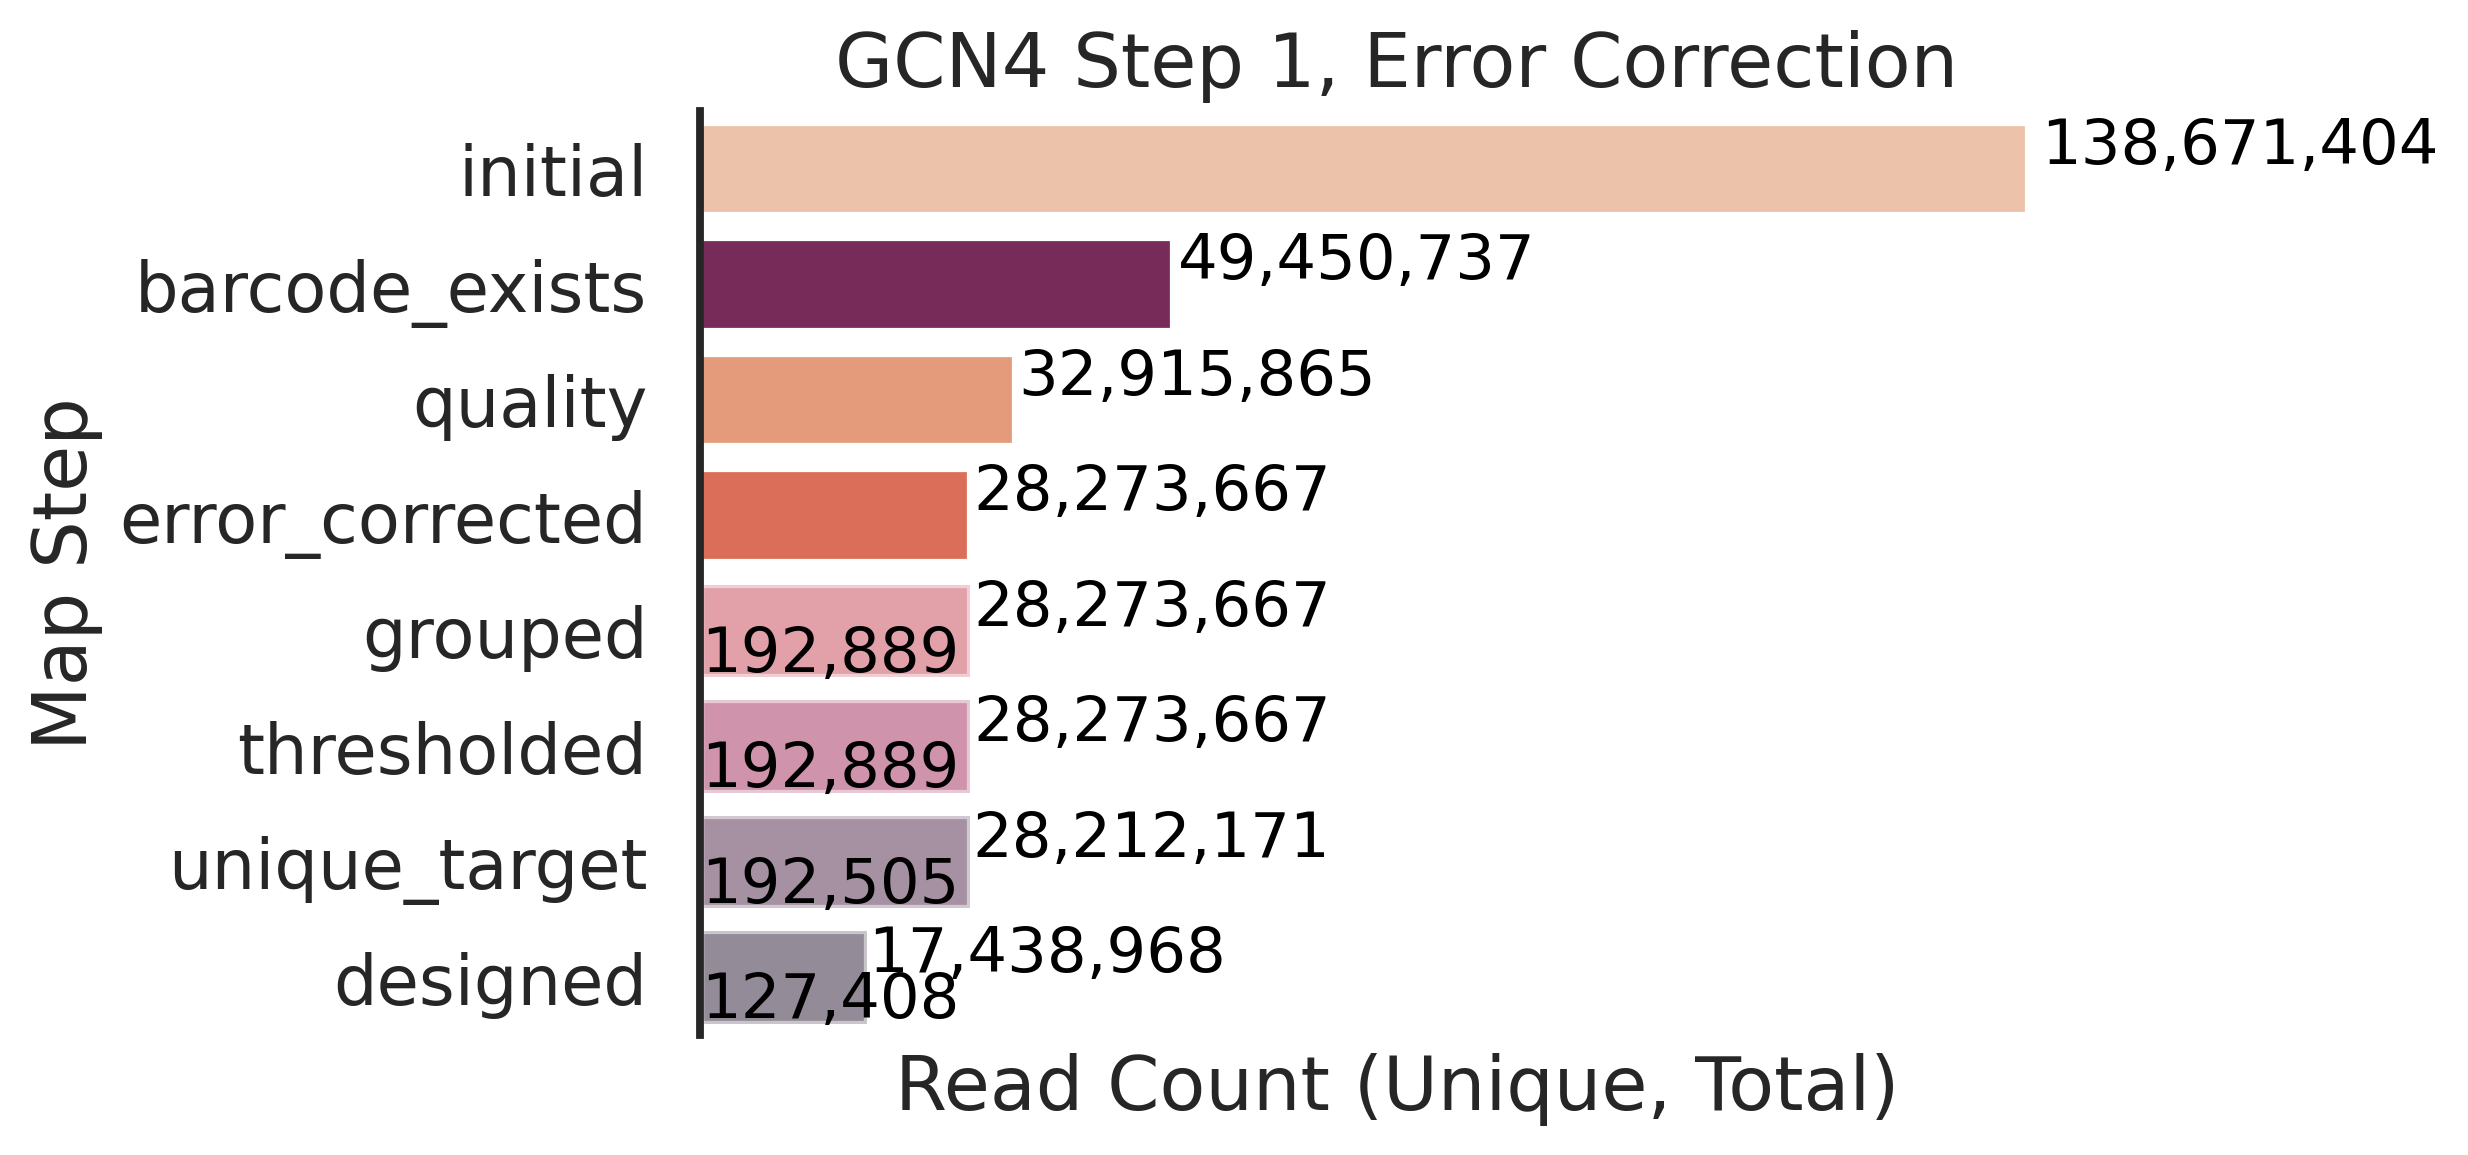

In [7]:
fig, ax = refiner.plot_loss(text_offset = -0.2)
ax.set_title("GCN4 Step 1, Error Correction")

# Step 2 Spike-In

## 1. AD + ADBC

In [9]:
AD_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*AD*.assembled.fastq")
AD_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0069_I1_AGCGAGCCAT_ACCGTAGATA_S6.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0070_I1_TCCAGAACTC_ACGTGAGCGA_S7.fastq.gz.assembled.fastq']

In [97]:
step2_AD_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
        seq_file=AD_step2_paths,
        step_name="step2",
        bc_objects=[EC_AD, EC_AD_BC],
        reverse_complement=True,
        design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv"
    )
step2_AD_mapper.create_map()

Reading 2 FASTQ/TXT file(s)...
Done in 1.43 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.30 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 2.84 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 1.62 seconds.

Mapping complete.


In [11]:
step2_AD_mapper.preview_map()

step2_AD_AD_BC_initial
Total rows: 528664


,AD,AD_qual,AD_BC,AD_BC_qual,Designed
0,TGGGGTTCATGCTGCTACTGCTGAACATCCAGCTATTAGAAGATTG...,True,TACACCCTTTG,True,1
1,GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...,True,GCAGCTTCGTC,True,1
2,TGTCCAATTTCTAATGAAATCTTGGGTTTGACTCCAGAATTGGTGG...,True,CTAGCTAGCCT,True,1
3,ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...,True,CCAGCACGTGC,True,1
4,GATTTGAACTTTGGTCATCAATTGATTCATTTGGTTCTTCTTCTTT...,True,GATGTGGTGGT,True,1


In [45]:
# Refine ADBC map
step2_AD_ADBC_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
                                                bc_objects=[EC_AD, EC_AD_BC],
                                                column_pairs = [],
                                                design_check = True,
                                                map_order = ['barcode_exists', 'quality', 'error_corrected', 'grouped', 'thresholded', 'designed'],
                                                step_name="step2",
                                                should_check_exists = False,
                                                design_file = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                              reads_threshold = 10,
                                              manual_ec_threshold = True,
                                              plot_histograms=True,
                                                output_figures_path="../../output/GCN4_error_corrected/step2/figures/"
)
step2_AD_ADBC_refiner.refine_map_from_db()

Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. designed



Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.14 seconds.



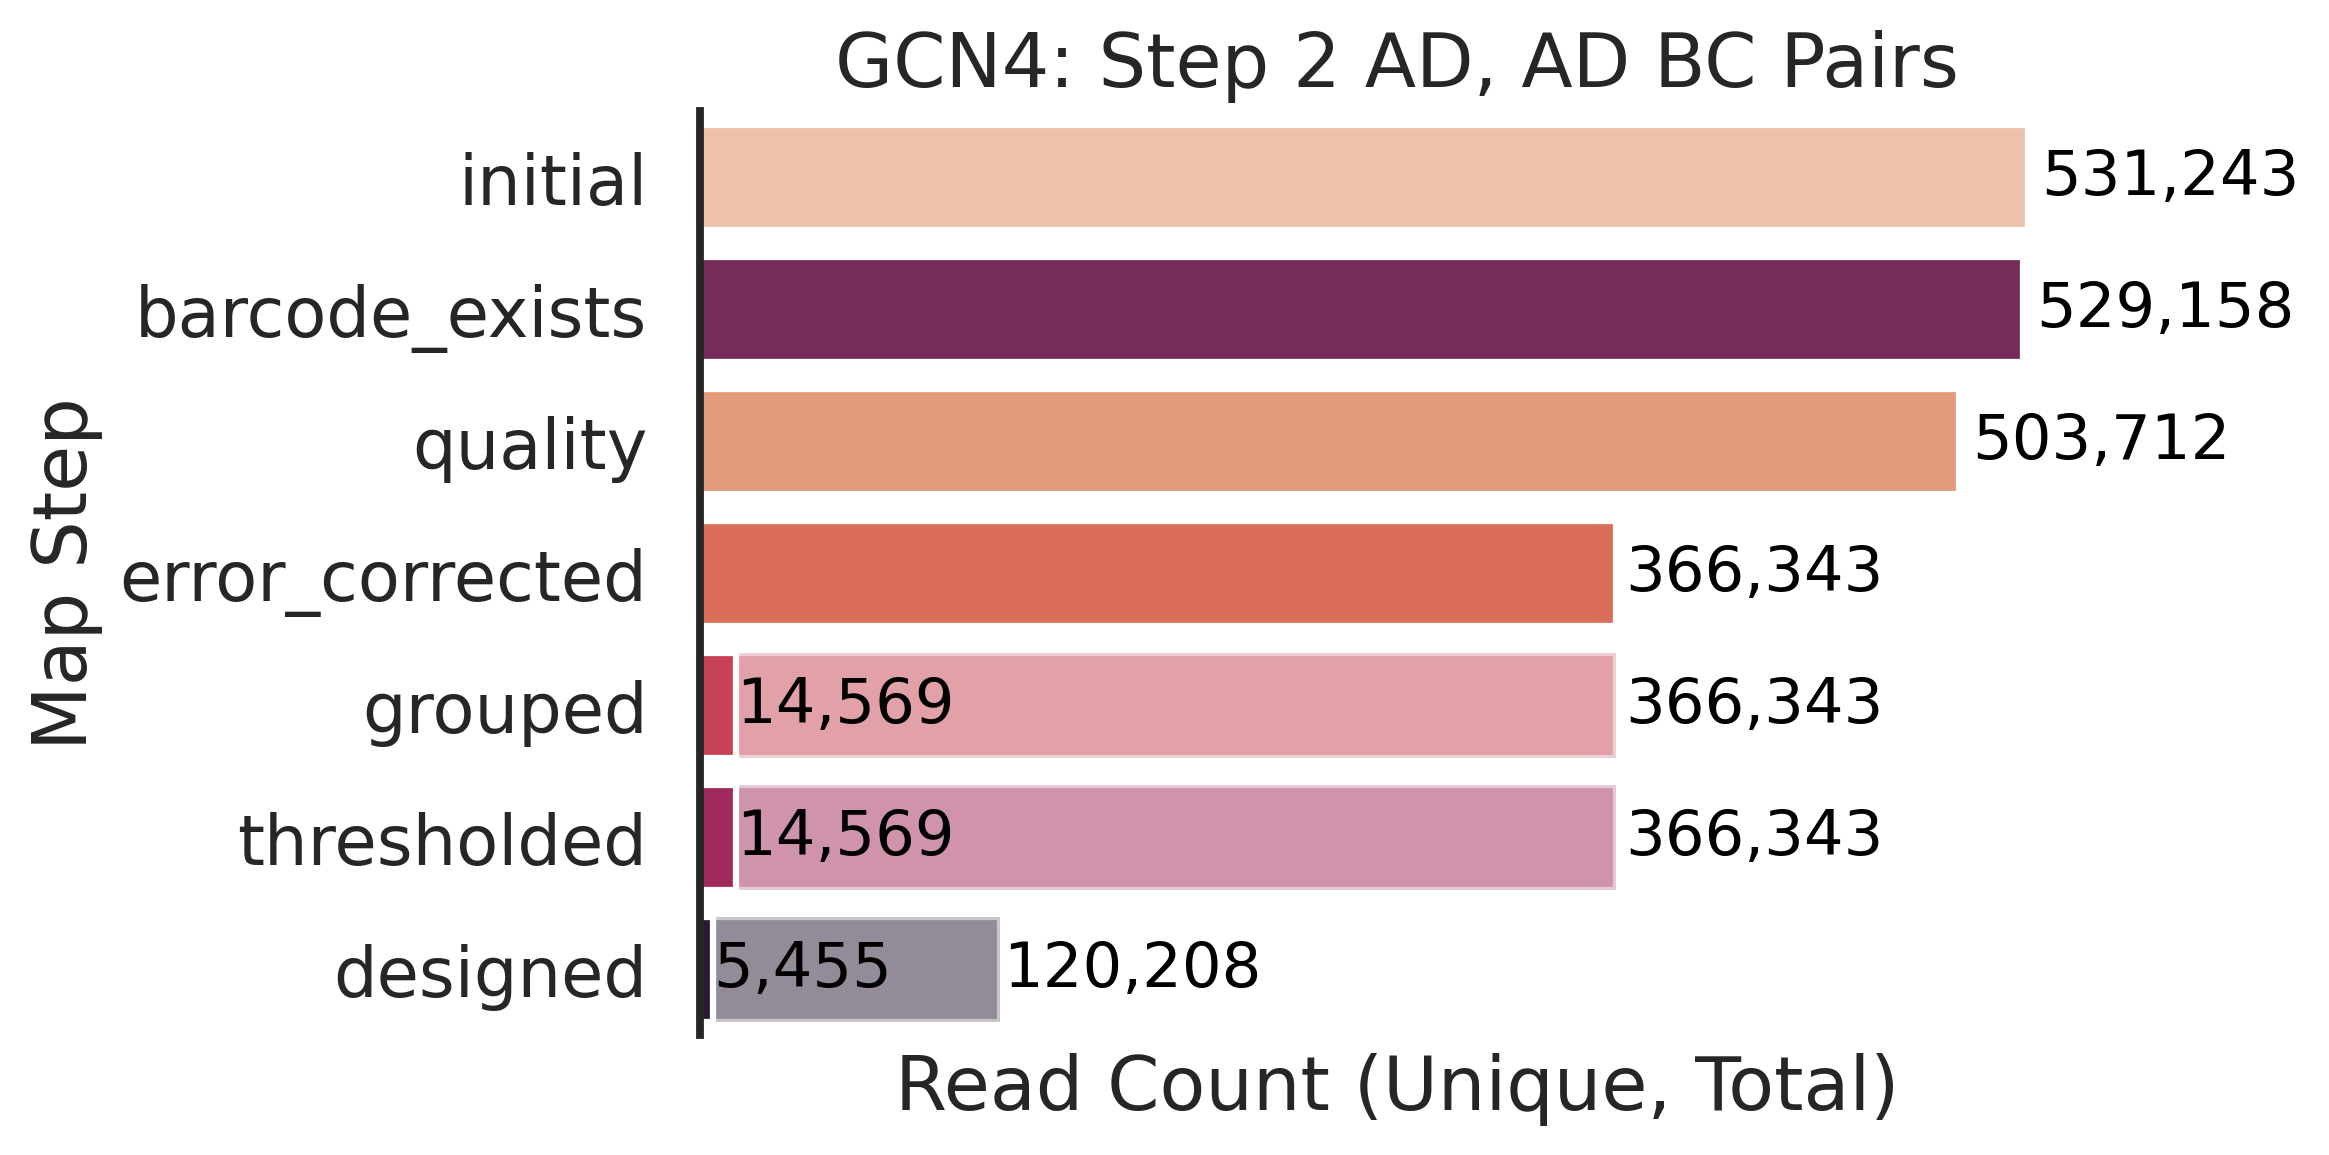

In [46]:
ax = step2_AD_ADBC_refiner.plot_loss()
plt.title("GCN4: Step 2 AD, AD BC Pairs")
plt.show()

In [67]:
initial = step2_AD_ADBC_refiner.get_map_df('initial')
initial

,AD,AD_qual,AD_BC,AD_BC_qual,Designed
0,CCAATTATCCATCTGTTAGAGCTGCTCCATCTTATTCTTCTTCTGG...,True,GGTCCAAAAGA,True,0
1,GAACCTAAGAAGAGAACTACTAGGAAGAAGAAAGATCCAAATGCTC...,True,CTTTACAGTTT,True,0
2,CCAGATTCATTTGTCTTTAAGTTTATATGATTATGGCTATTGGTTG...,True,TGGTTTCTCCT,True,0
3,AGAACTCATTCTATCCAATGAACTCTGGTAATAATTATTTGCCATC...,True,ACGGTGATAGT,True,0
4,GCTGGTAAGAAGAAGAATTATACTGCTTCTGTTGCTGCTTCTAAGA...,True,TGGAGGTACGC,True,0
...,...,...,...,...,...
531238,TTGTTGGCTGAACCATCTCCAATGGTTTGTCTGATGAAACTATTTC...,True,CTGACGAAGAC,True,0
531239,CTATGAGACCAACTGACTTCTCTGATTTGGAAGACTTTACTGCATT...,True,CGATCCCGTAT,True,0
531240,,False,CCTCCCGCTTC,True,0
531241,ACACTTCTCCATCTGACTTTAATGTTCTCCATATGGTGATTCTTAT...,True,CCATAGTATGA,True,0


In [68]:
initial[["AD_qual", "AD_BC_qual", "Designed"]].value_counts()

AD_qual  AD_BC_qual  Designed
True     True        0           325437
                     1           178275
False    True        0            25445
True     False       0             1352
                     1              680
False    False       0               54
Name: count, dtype: int64

In [69]:
error_corrected = step2_AD_ADBC_refiner.get_map_df('error_corrected')
error_corrected[["AD_qual", "AD_BC_qual", "Designed"]].value_counts()

AD_qual  AD_BC_qual  Designed
True     True        0           246135
                     1           120208
Name: count, dtype: int64

## 2. RPTR BC

In [8]:
RPTR_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*RPTR*.assembled.fastq")
RPTR_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v1_MVS_0065_I1_CTATGGCGGA_CGGTAGAATT_S2.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v2_MVS_0067_I1_GTCTTGTGCC_TCATGTAGGA_S4.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v1_MVS_0066_I1_TGGCTGCTGA_GCCAGTCTGT_S3.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v2_MVS_0068_I1_TCGAGGTTAA_CTCGCAGCAA_S5.fastq.gz.assembled.fastq']

In [10]:
step2_RPTR_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
        seq_file=RPTR_step2_paths,
        step_name="step2",
        bc_objects=[EC_RPTR_BC],
        reverse_complement=True,
    design_file_path = None
    )
step2_RPTR_mapper.create_map()

Reading 4 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 6.01 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.43 seconds.

Extracting 1 barcodes...
Regex for RPTR_BC: CTCGAG(.{1,14})
Done in 0.80 seconds.

Done in 0.00 seconds.

Done in 1.13 seconds.

Mapping complete.


In [11]:
step2_RPTR_mapper.preview_map()

step2_RPTR_BC_initial
Total rows: 1304387


,RPTR_BC,RPTR_BC_qual,Designed
0,TGCTTATGCGCATC,True,1
1,TCTCCTCCCCTGCC,True,1
2,TGAGCGATATACGG,True,1
3,TATAATCTATGTAA,True,1
4,TTATCTGATGAAAG,True,1


Base prefix (stable across descriptors): step2_RPTR_BC_
Full prefix for this instance: step2_RPTR_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded

Removing rows with null or empty barcodes (excluding AD)...
Done in 1.55 seconds.


Filtering to high-quality reads...
Created table: step2_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.44 seconds.


=== Running error correction step on step2_RPTR_BC_quality ===

=== Applying whitelist for step2 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/step2/figures/step2_RPTR_BC_filtered_barcodes_extracted.fastq
Wrote 1079580 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/step2/figures/step2_RPTR_BC_filtered_barcodes_extracted.fastq
Done in 0.65 seconds.

Inferring expected barcode count from grouped reads...
Using reads threshold of 10
Infe

/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/step2/figures/step2_RPTR_BC_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/step2/figures/step2_RPTR_BC_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/step2/figures/step2_RPTR_BC_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 27609
Done in 0.48 seconds.

Whitelist application complete for step2 at step2_RPTR_BC_error_corrected
Done in 1.31 minutes.

Grouping step2_RPTR_BC_error_corrected...


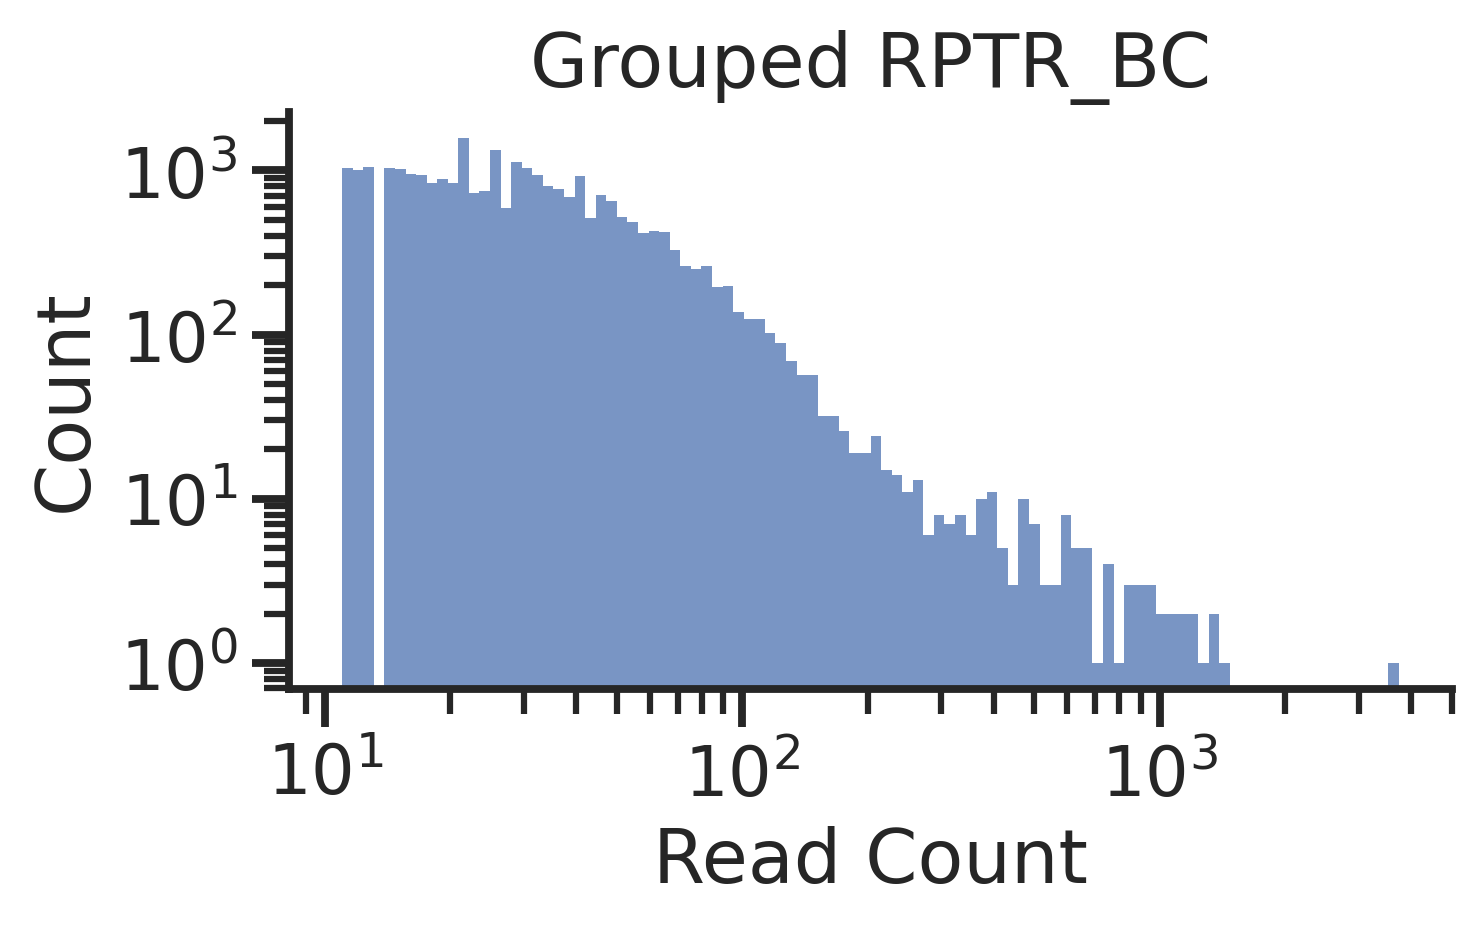

Done in 1.47 seconds.

Thresholding...
Using reads threshold of 10.


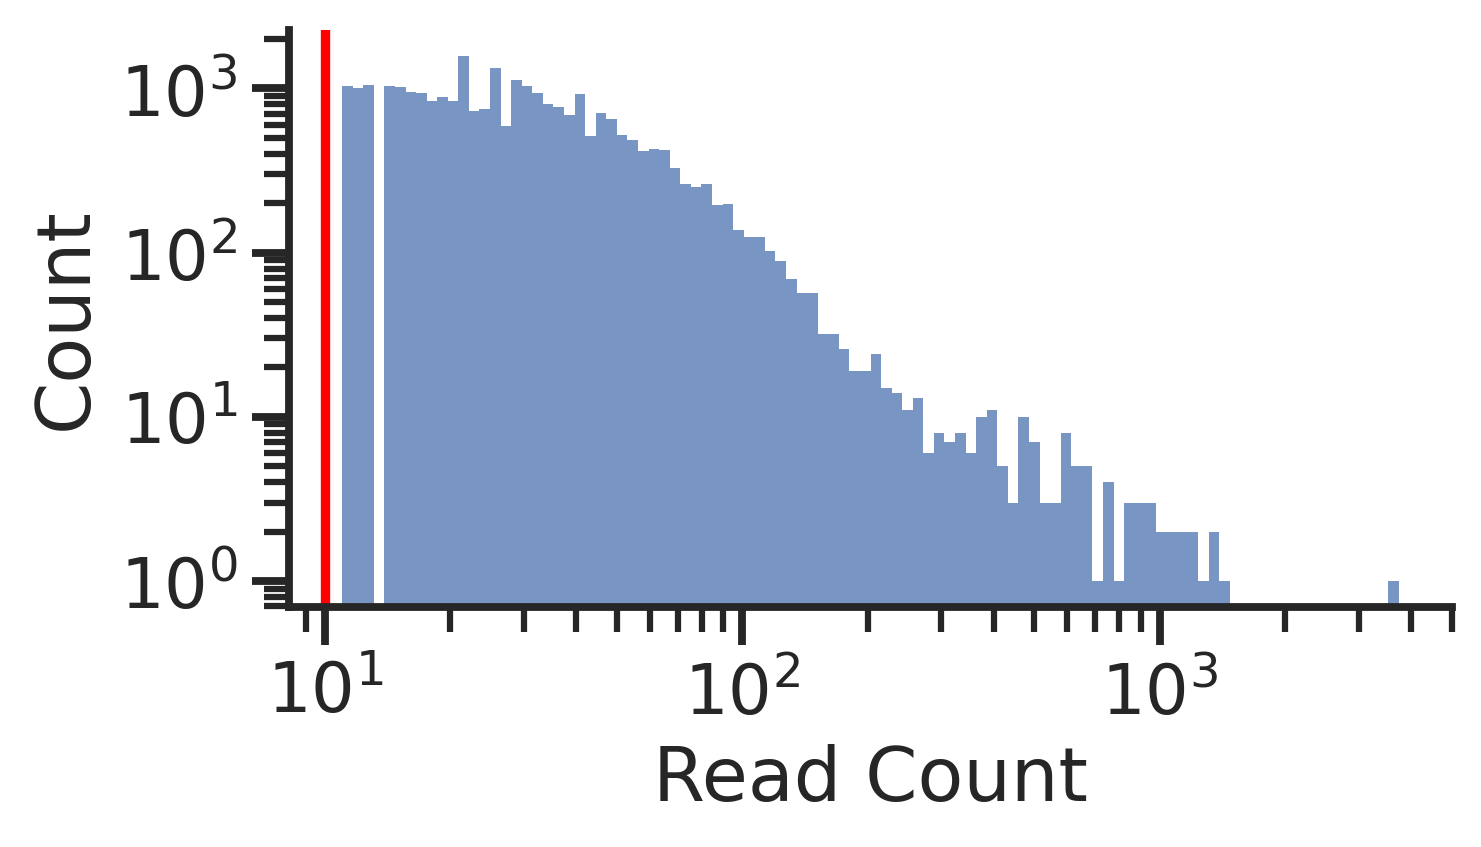

Done in 0.97 seconds.

Done.


In [13]:
# Refine RPTR map
step2_RPTR_refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
                                                bc_objects=[EC_RPTR_BC],
                                                column_pairs = [],
                                                map_order = ['barcode_exists', 'quality', 'error_corrected', 'grouped', 'thresholded'],
                                                step_name="step2",
                                           manual_ec_threshold = True,
                                           reads_threshold = 10,
                                                output_figures_path="../../output/GCN4_error_corrected/step2/figures/")
step2_RPTR_refiner.refine_map_from_db()


Saved loss summary table as 'step2_RPTR_BC_loss_summary'
Done in 0.05 seconds.



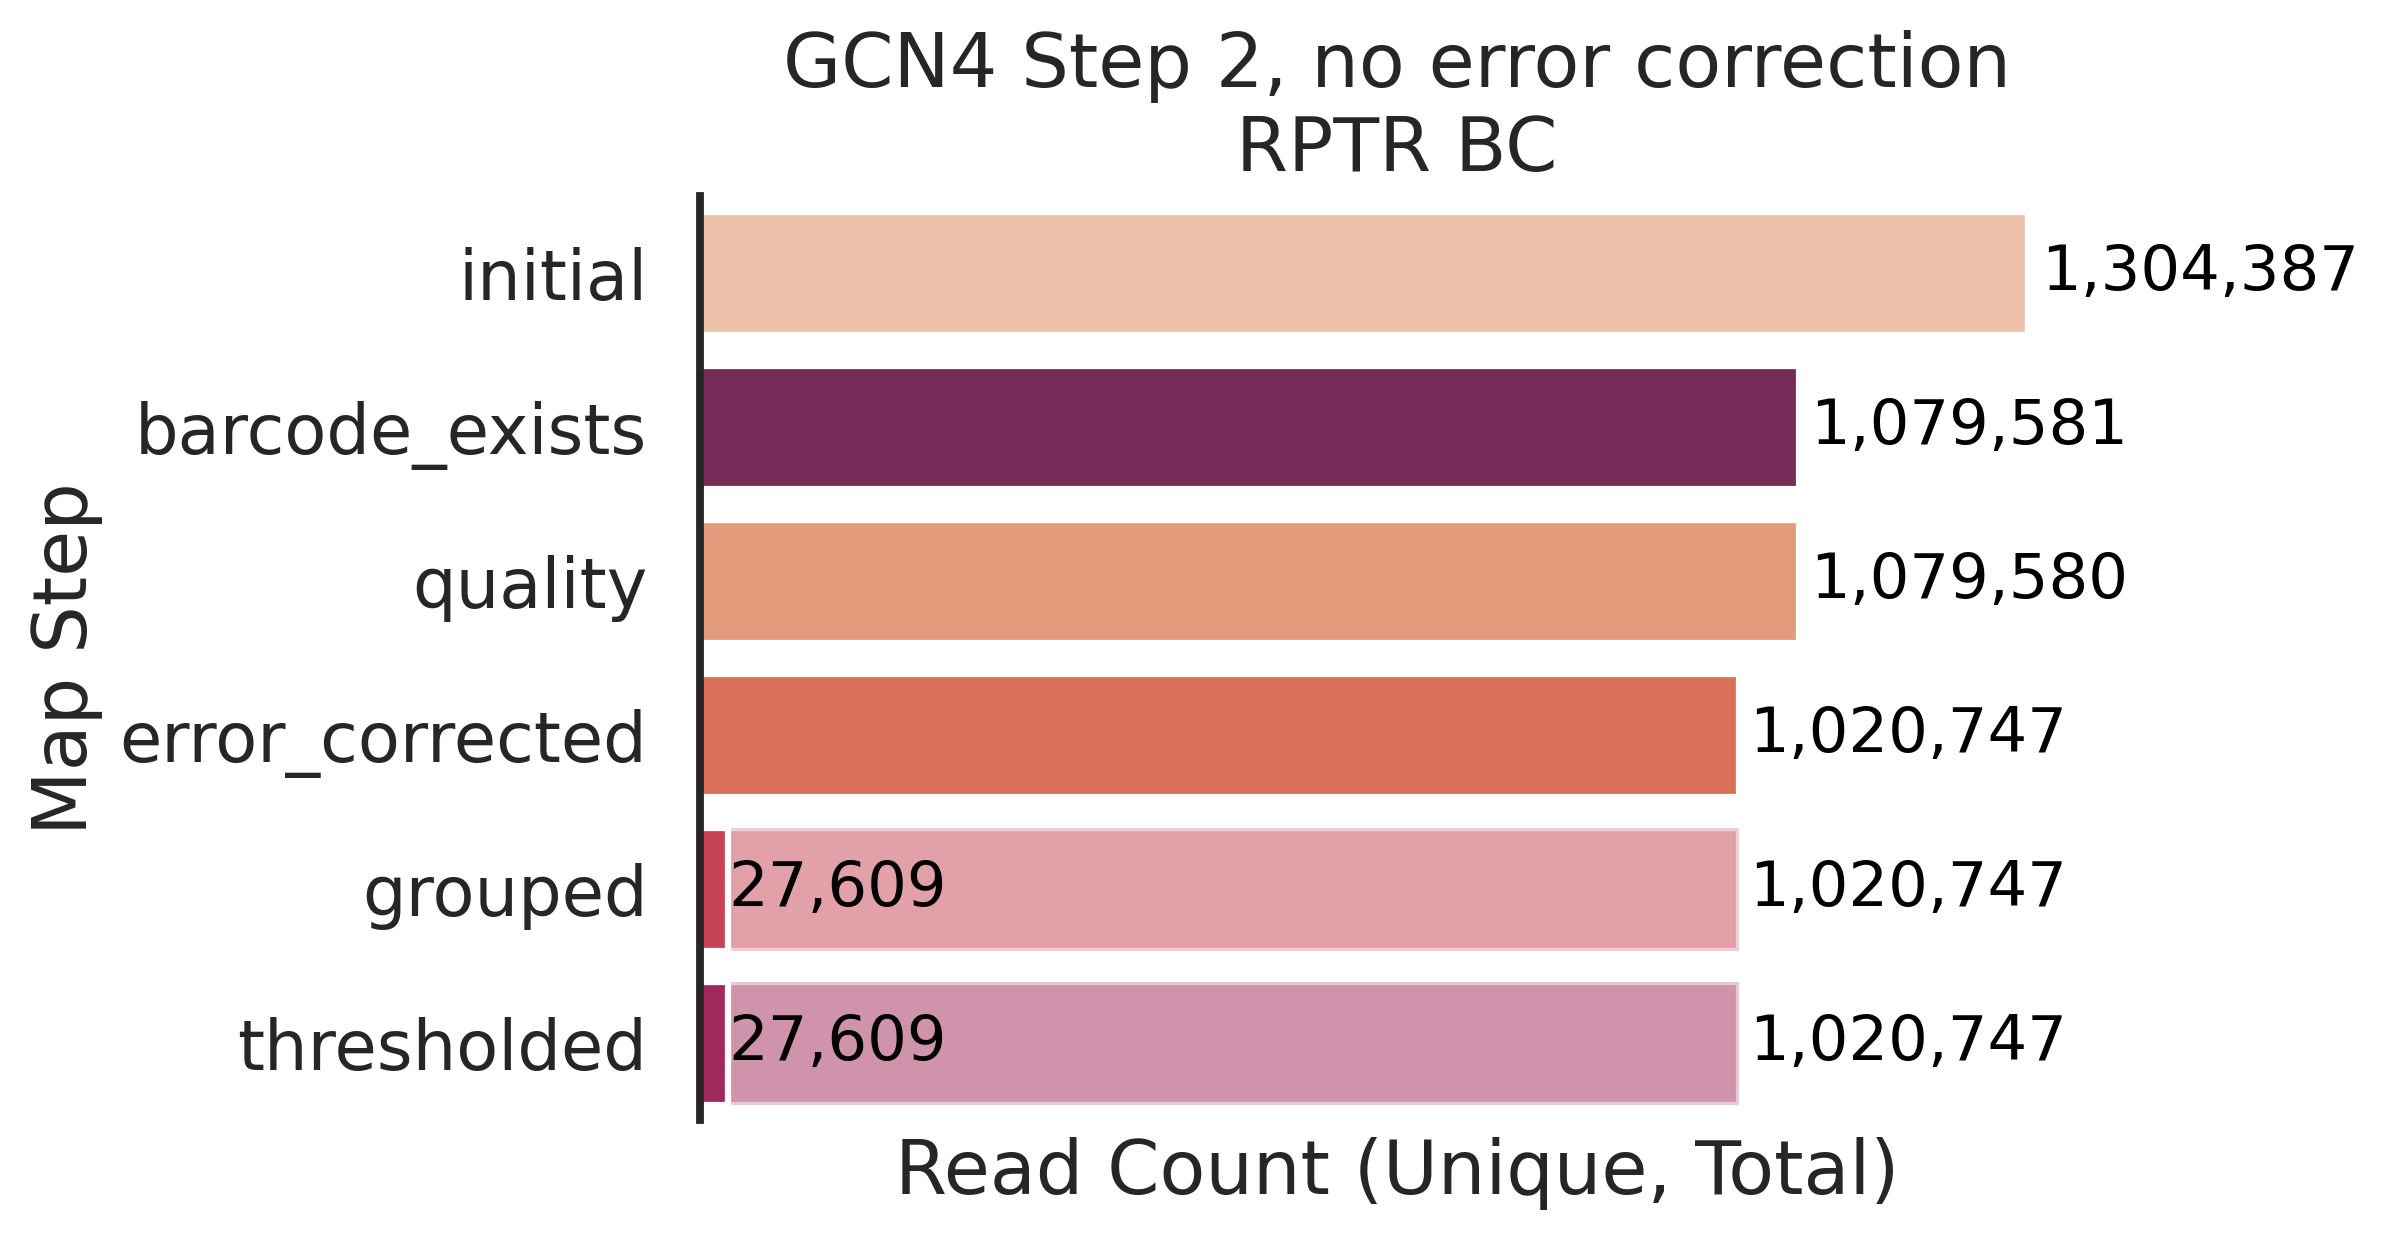

In [14]:
ax = step2_RPTR_refiner.plot_loss()
plt.title("GCN4 Step 2, no error correction\nRPTR BC")
plt.show()

In [77]:
complexity_checker = complexity.ComplexityChecker(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
                                                  step_name = "step2",
                                                  step1_map_name = "step1_AD_AD_BC_RPTR_BC_designed", 
                                                  step_suffix = "designed",
                                                  barcode_groups = [(EC_AD, EC_AD_BC), (EC_RPTR_BC)])
complexity_checker.count_overlap()

,BC_type,map_unique,step2,seen_in_both,percent_of_map_seen
0,"AD,AD_BC",127383,5455,4730,3.713
1,RPTR_BC,126943,27609,9735,7.669


# TREBL Experiments

## Yeast Pool A

### 1. AD + ADBC

In [9]:
yeast_pool_A_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/*")
yeast_pool_A_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/RPTR/*")
yeast_pool_A_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/yeast_pool_A" # May need to change to your directory due to writing permissions

In [10]:
yeast_pool_A_AD_seq_files

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-10-1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-5-2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-0-2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_67p

In [11]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db"

Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. designed

Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_loss_summary'
Done in 0.14 seconds.

Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S

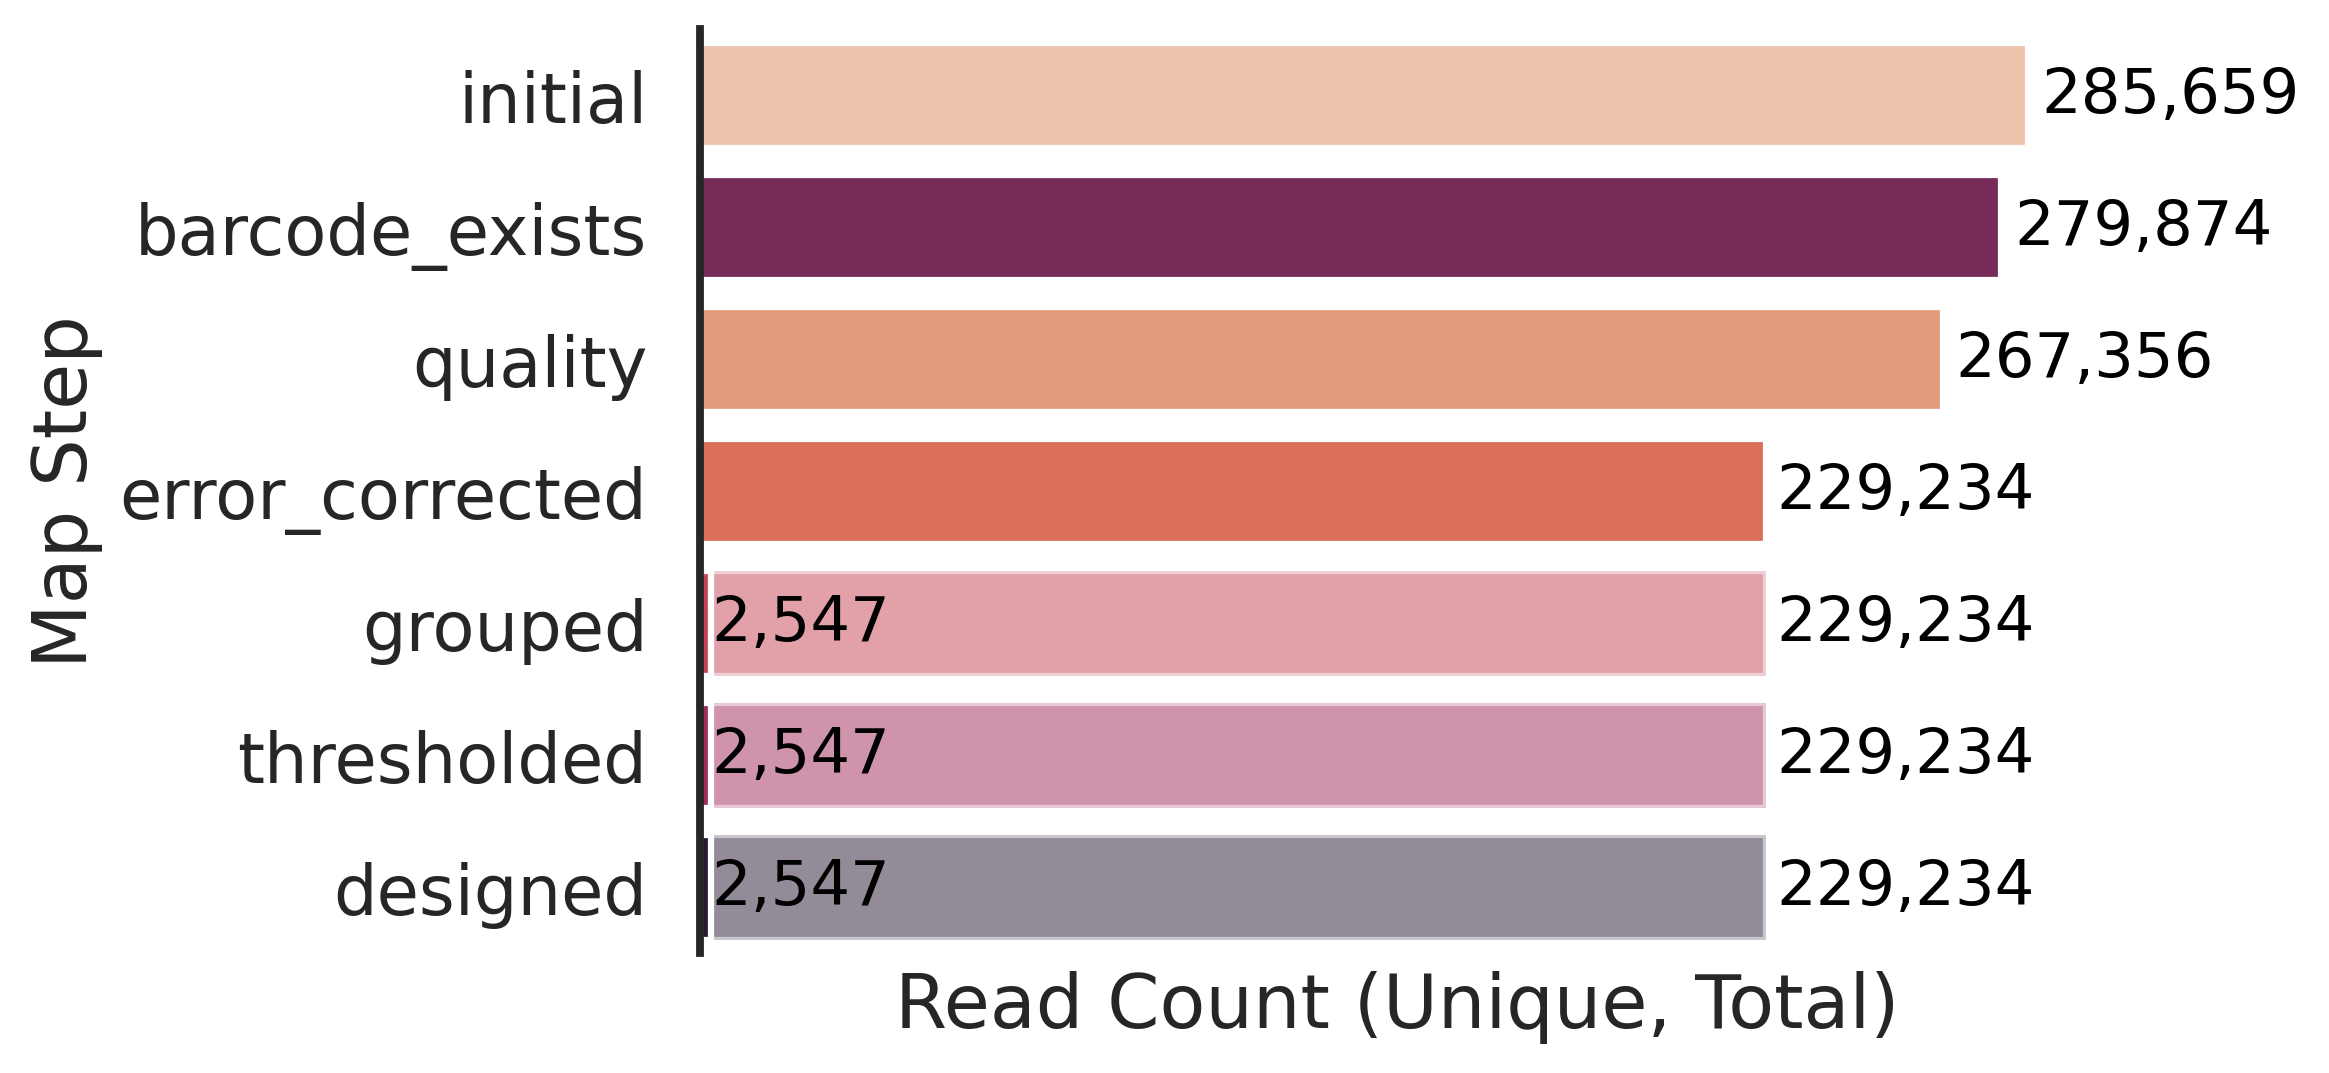

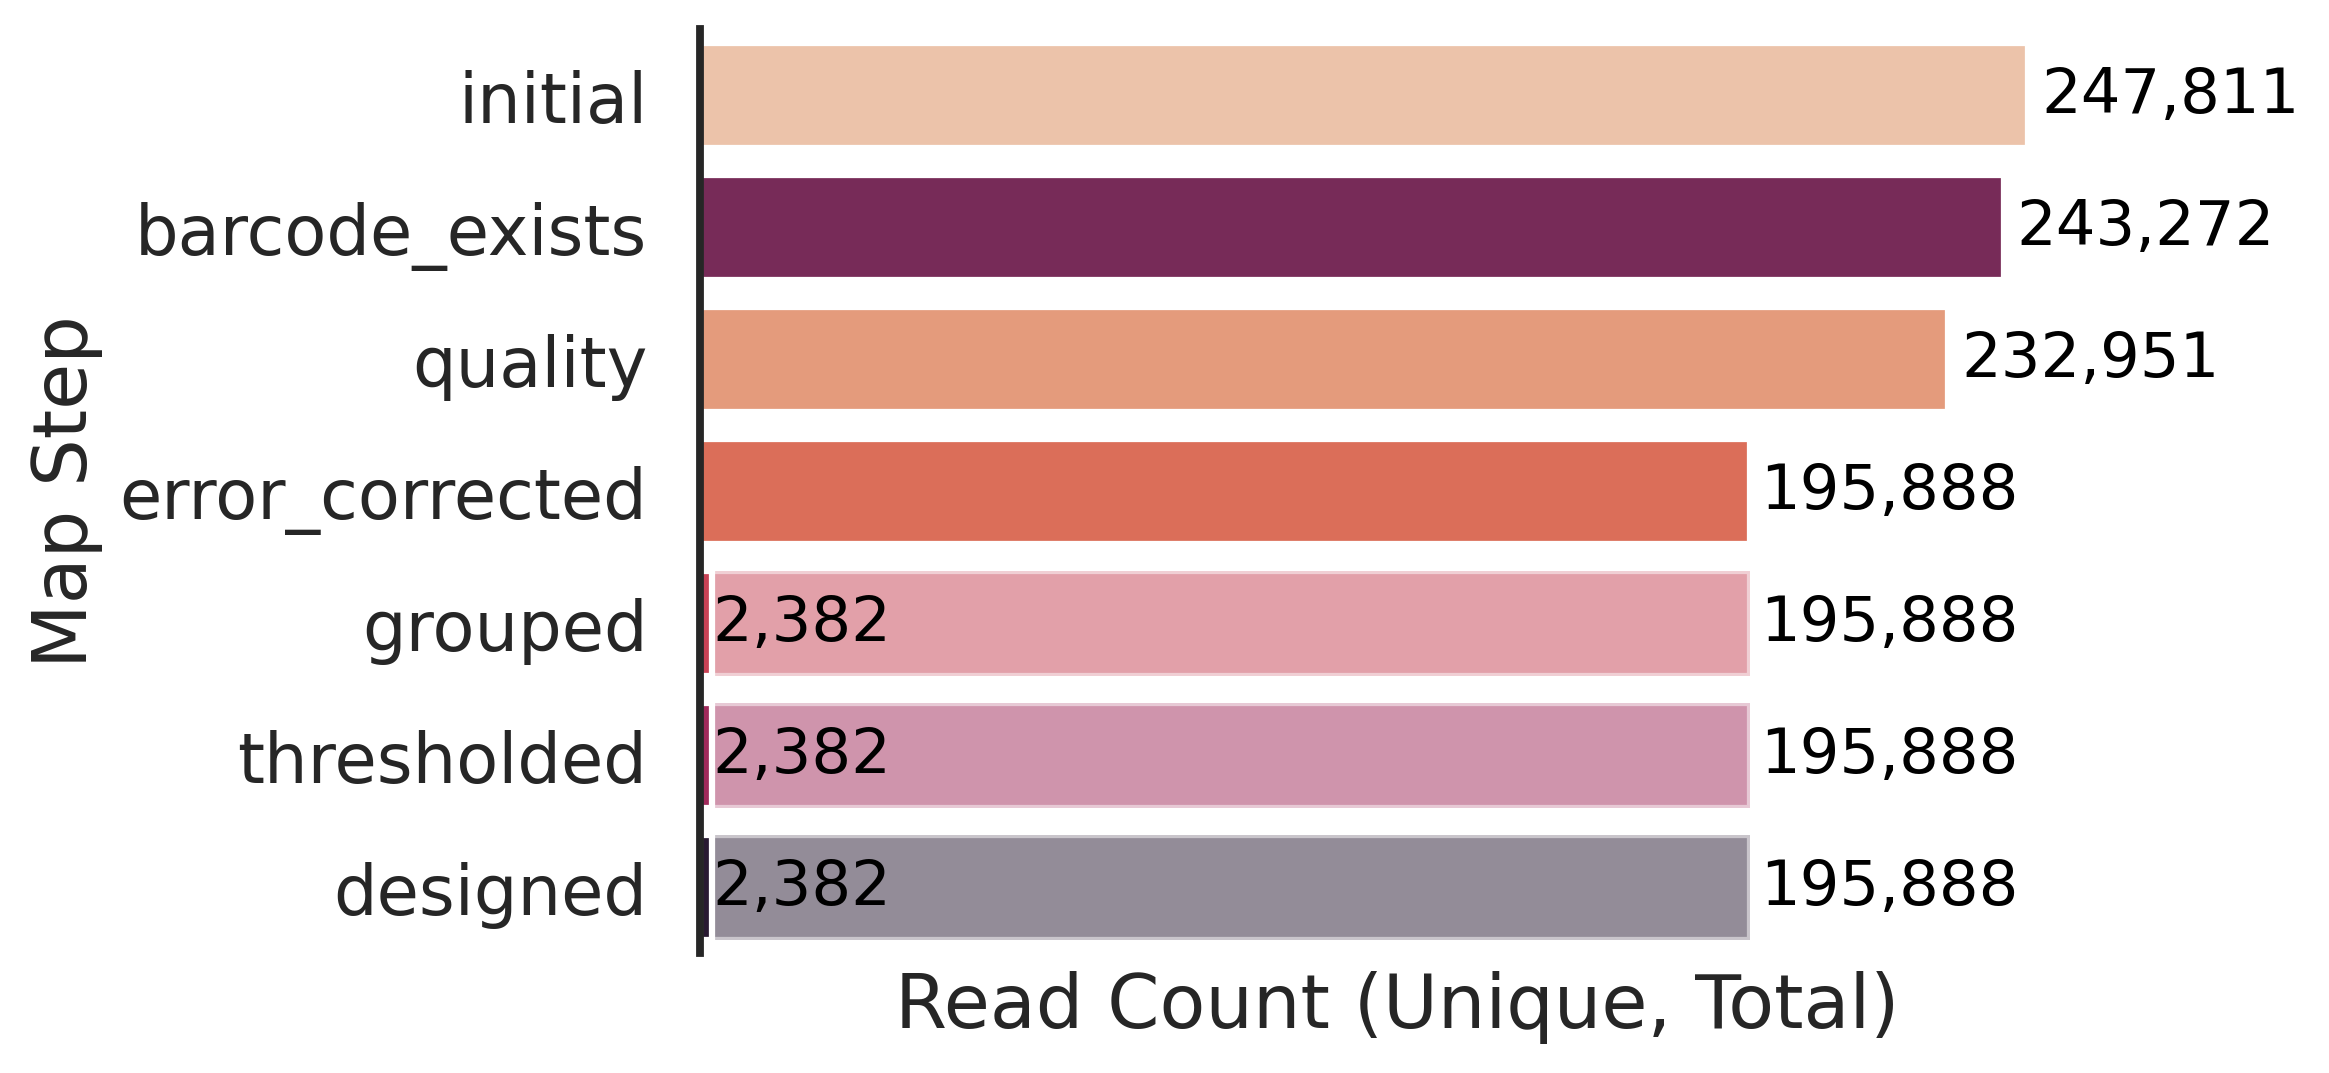

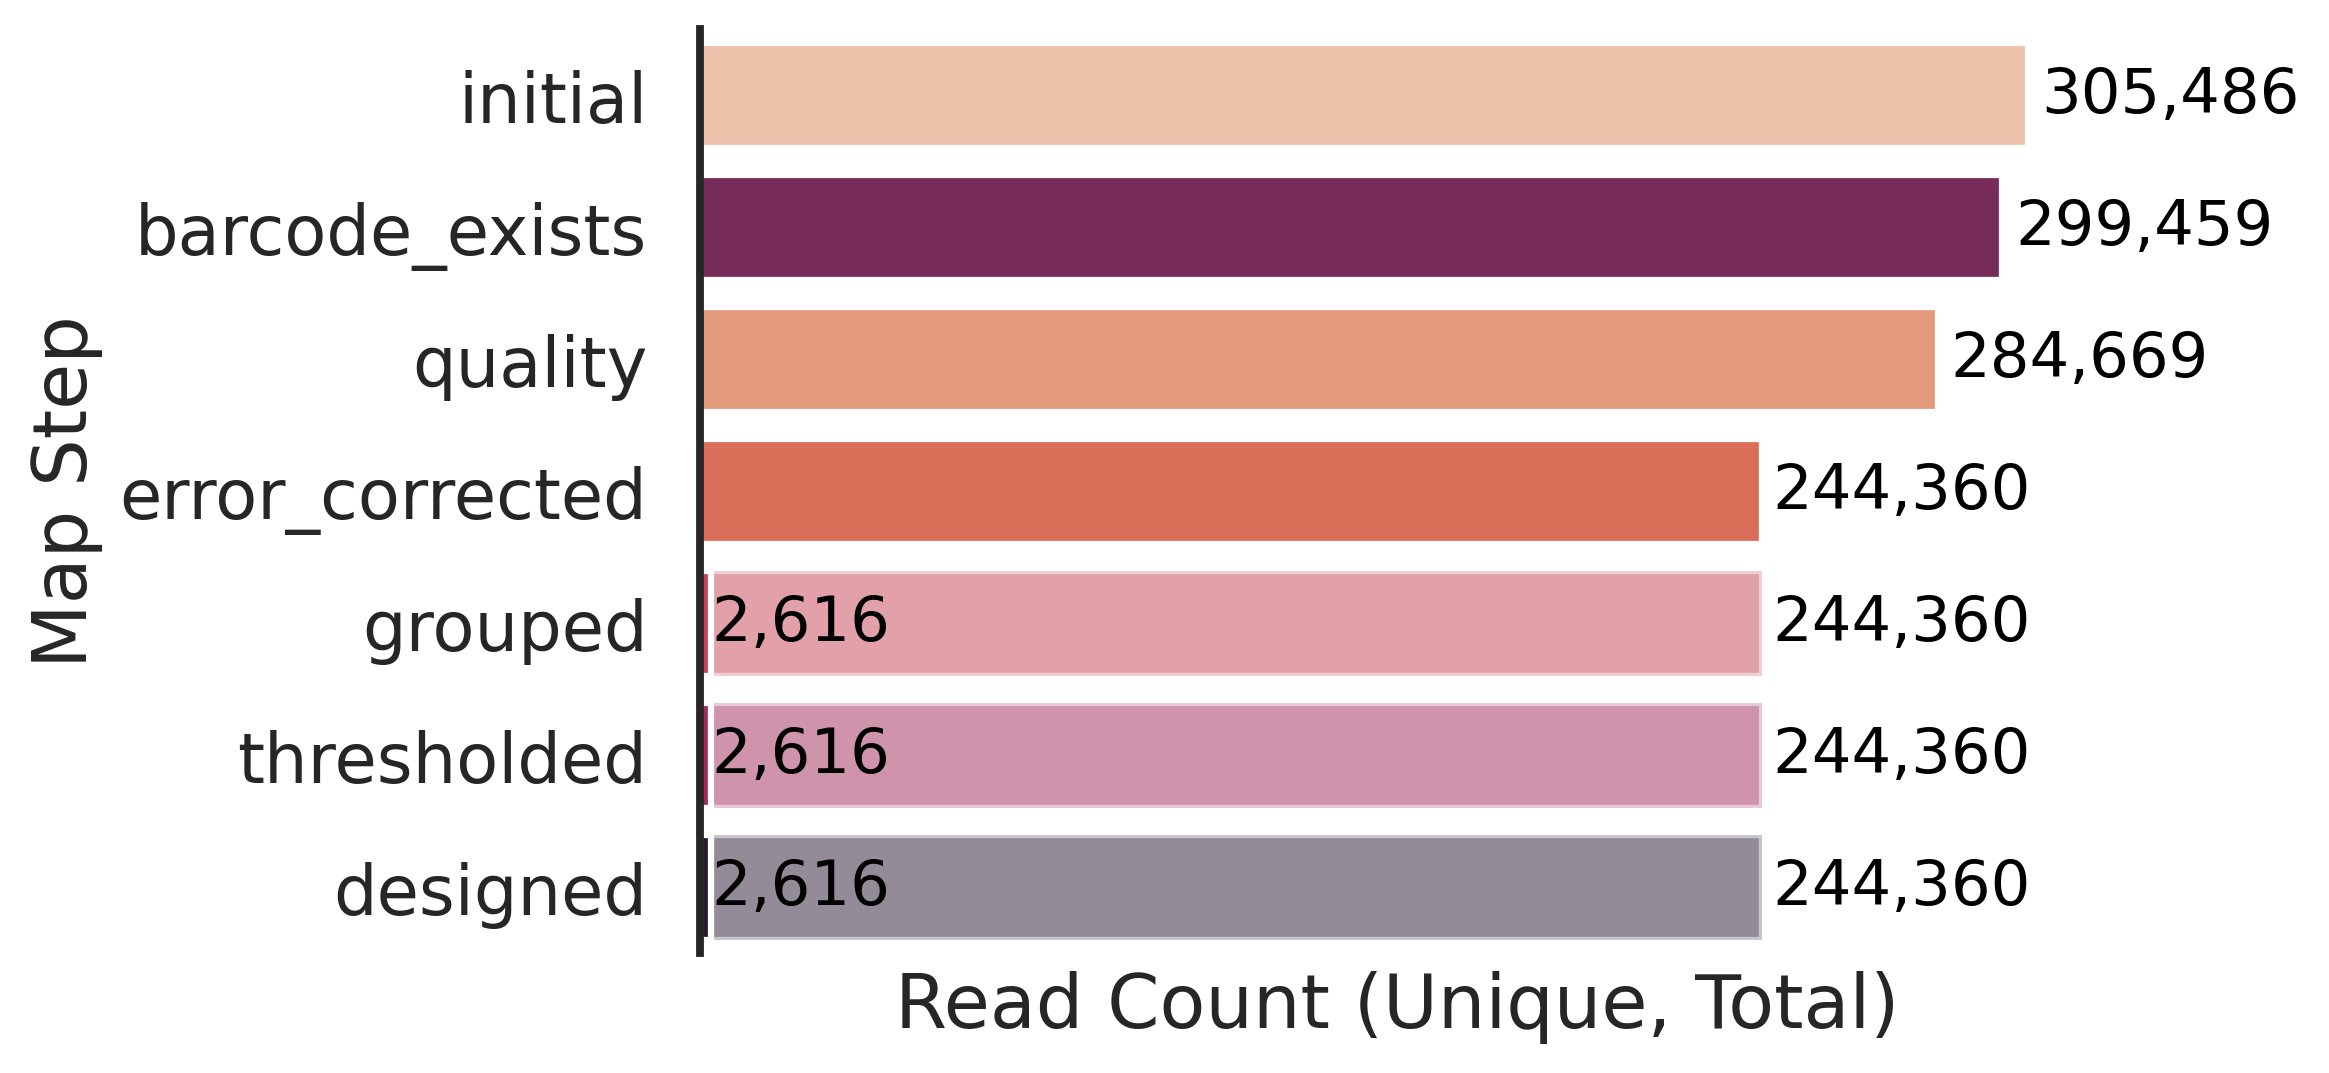

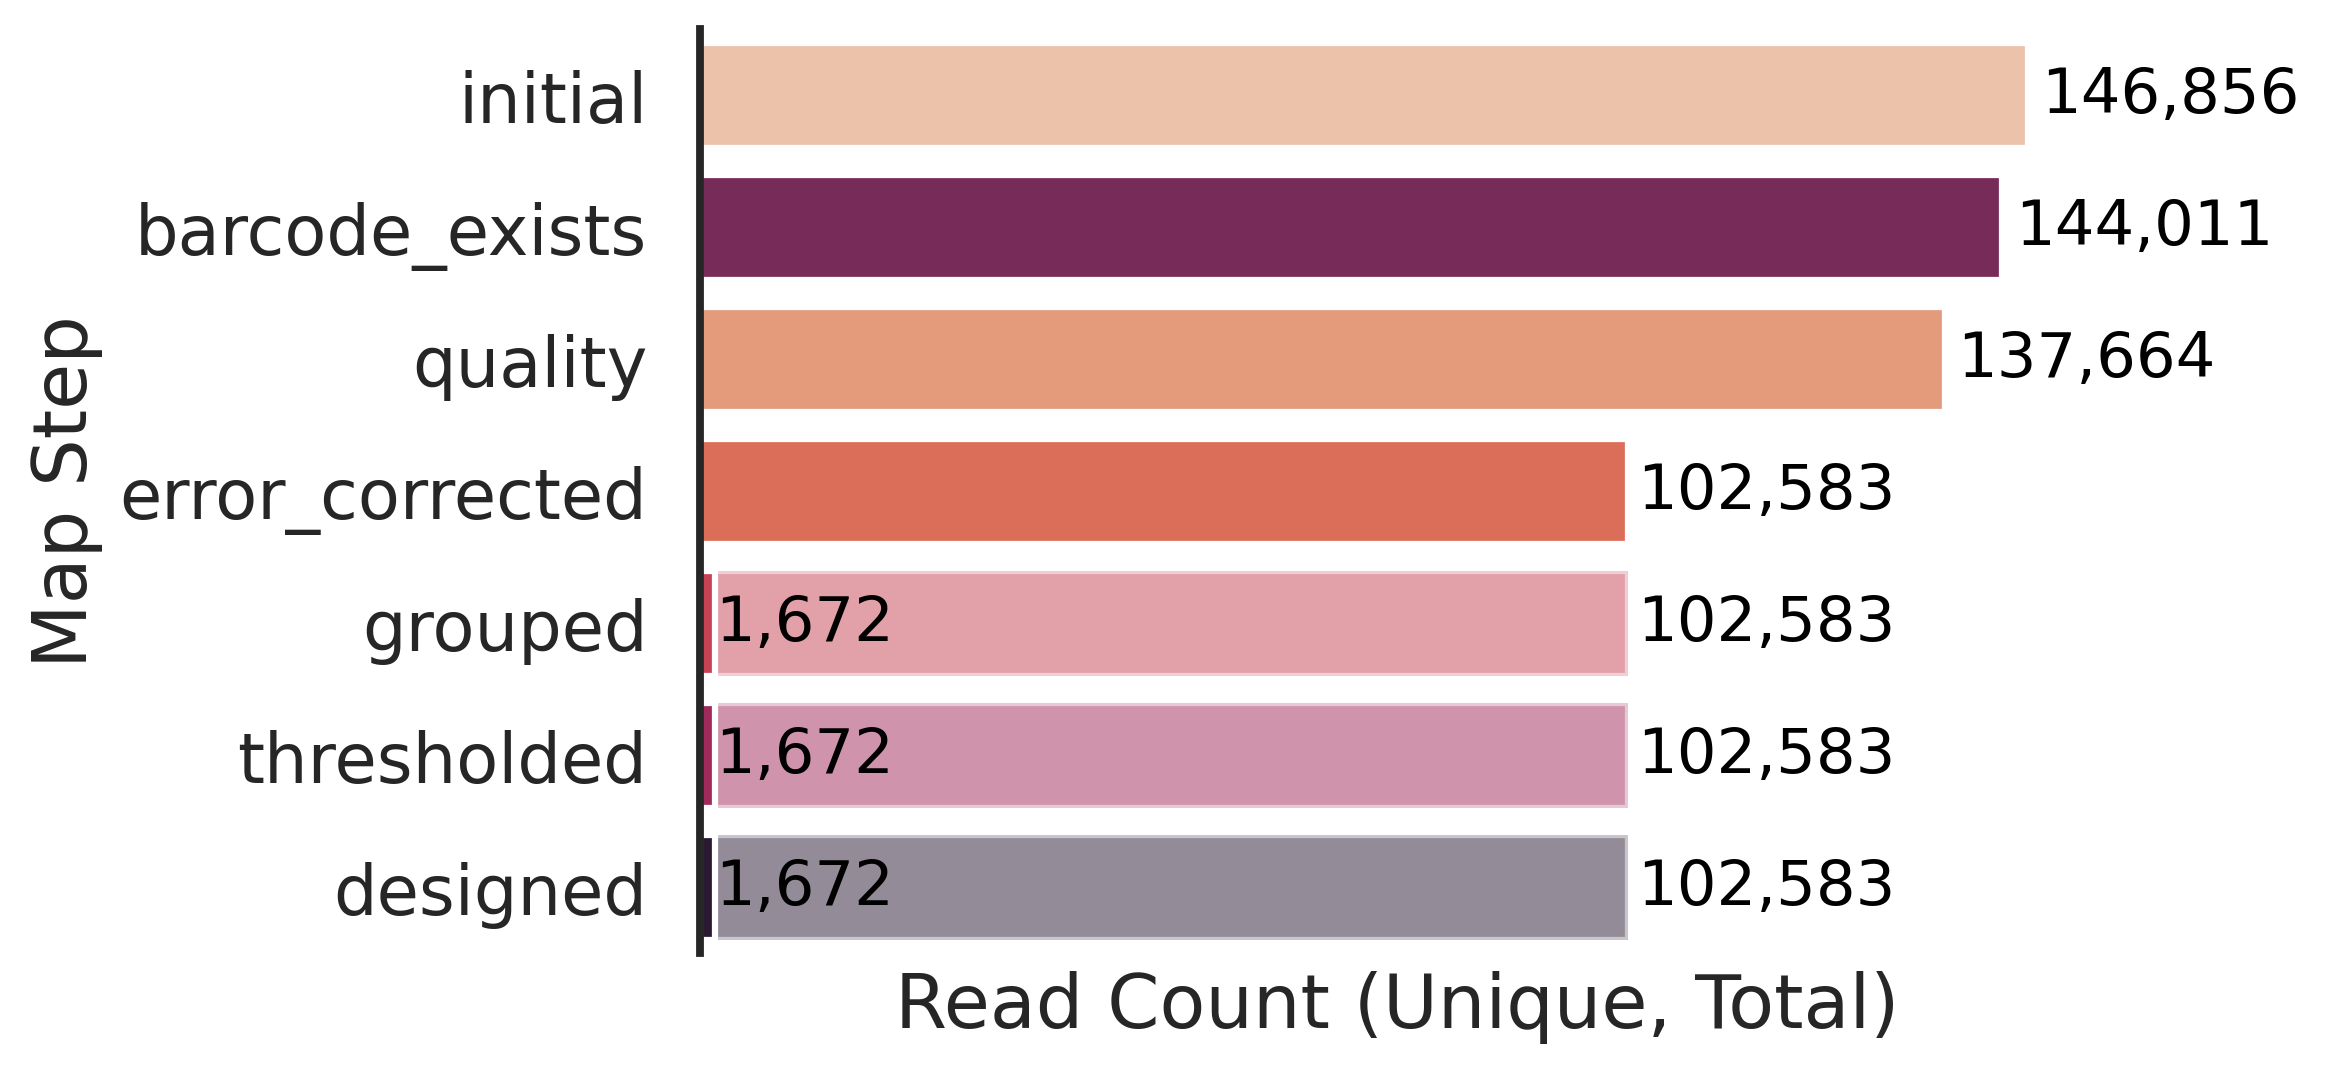

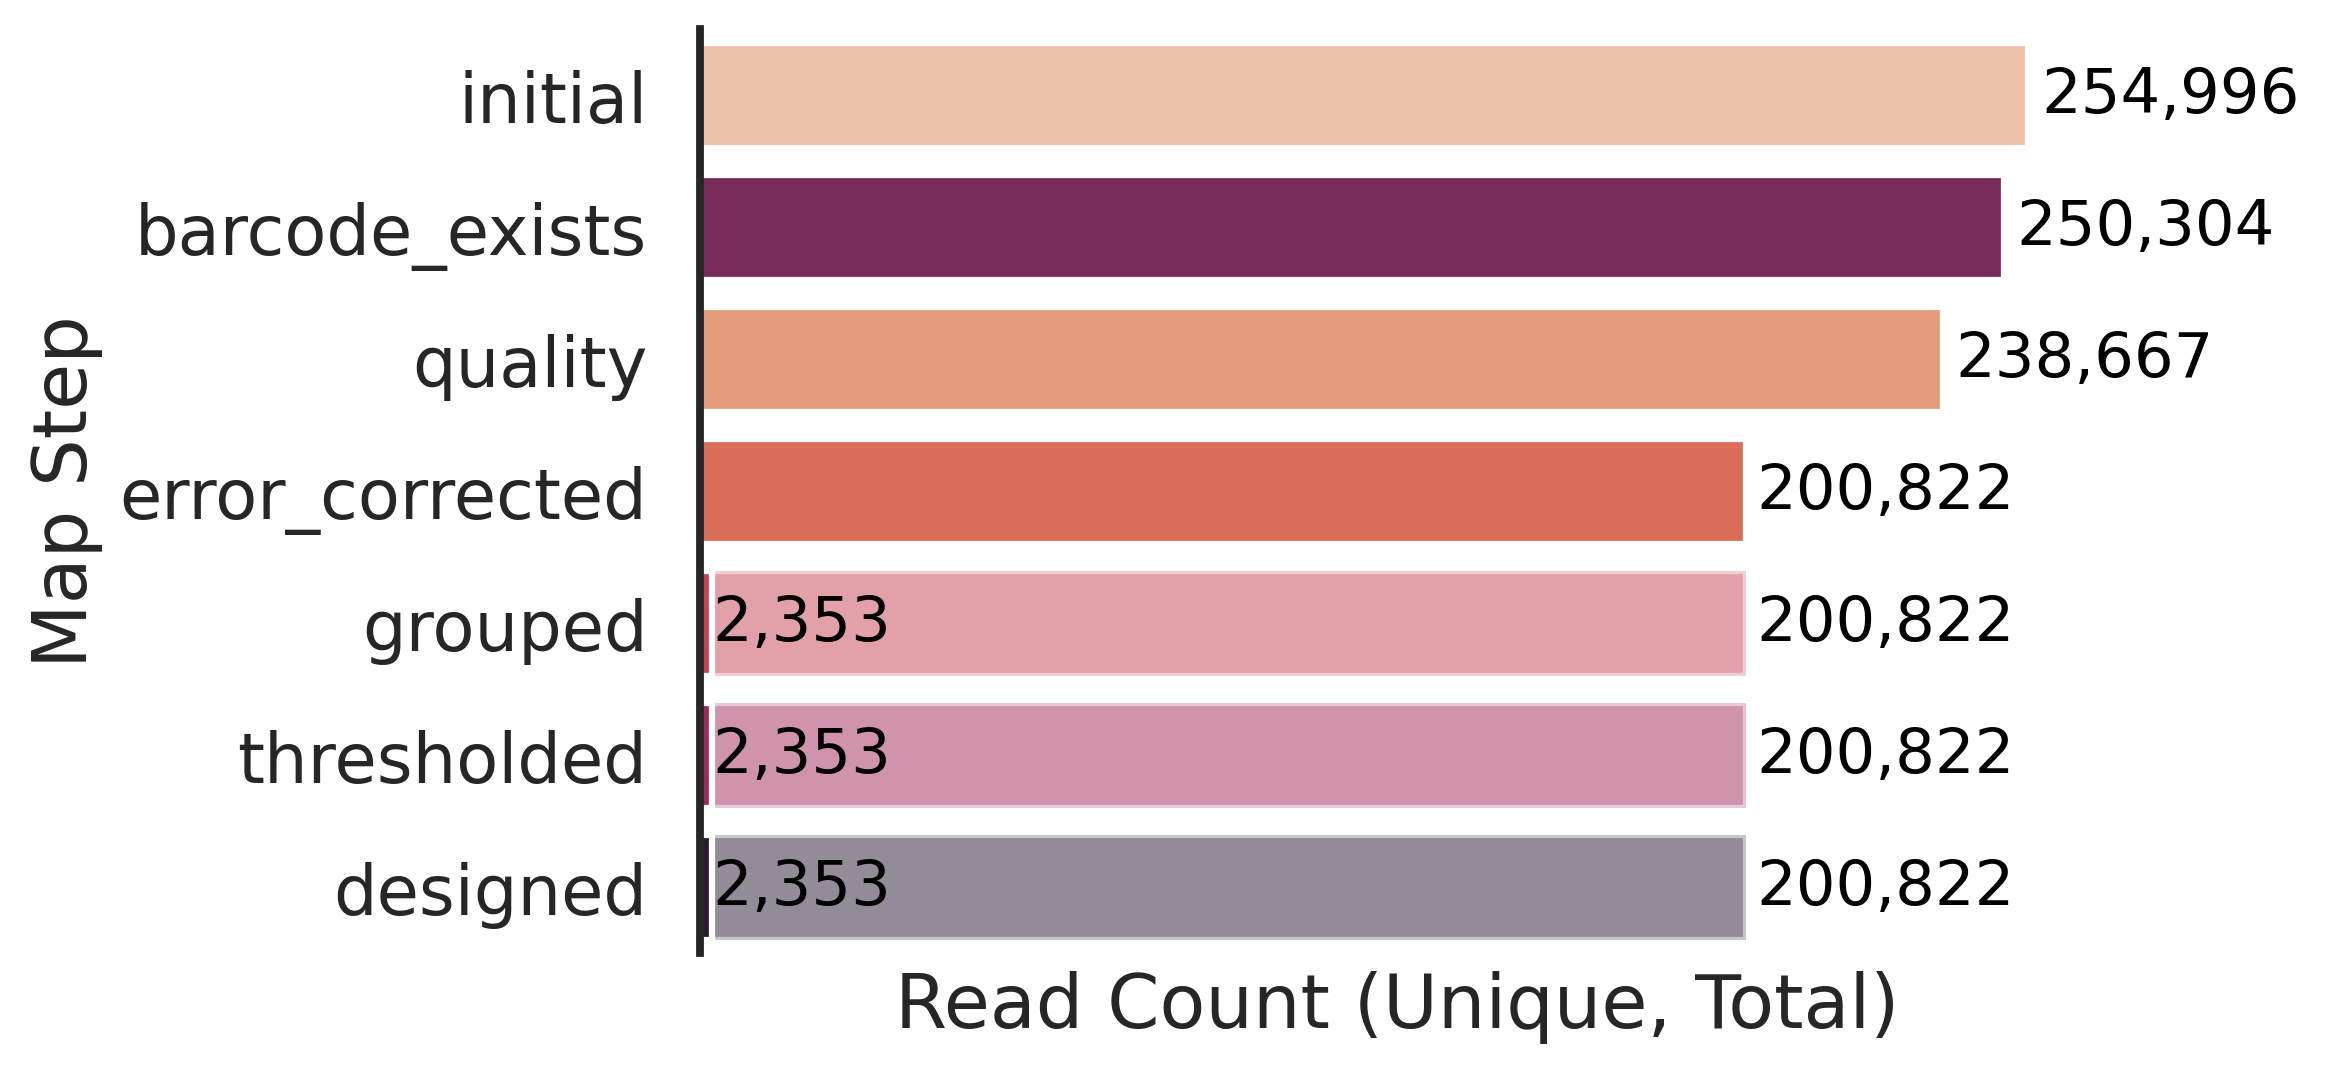

In [25]:
AD_objects = [EC_AD, EC_AD_BC]

complex_AD_results = []
simple_AD_results = []

for file_path in yeast_pool_A_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['barcode_exists', 'quality', 'error_corrected', 'grouped', 'thresholded', 'designed'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = True,
                                    reads_threshold = 20,
                                    manual_ec_threshold=True,
                                    output_figures_path='/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/yeast_pool_C_umi/figures',
                                        plot_histograms=True)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [26]:
tables = refiner.show_tables()

yeast_pool_A_AD_result_tables = []

for table in tables:
    if "trebl" in table[0] and "AD" in table[0] and "thresholded" in table[0]:
        print(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_AD_result_tables.append(df)

yeast_pool_A_AD_result_df = pd.concat(yeast_pool_A_AD_result_tables)
yeast_pool_A_AD_result_df

trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded


,AD,AD_BC,count,AD_qual,AD_BC_qual,Designed,sample
0,GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...,CTCCACTGCCC,729,True,True,1,AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...
1,TCTCATACTACTACTGTTACTCAAACTGTTGTTTCTTCTAAACCAG...,CGTCCGATAAG,463,True,True,1,AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...
2,GGTAATGTTCCACAAACTCCAAAATGGCTATGCAAGGTAAATTTCA...,CCAATCCTACT,445,True,True,1,AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...
3,CAACCAAATCCATATTTGAGAGCTTTGGCTTTGTCTCCAACTCCAG...,TAGAATAAGAC,424,True,True,1,AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...
4,GATCAATCTCCAGGTATCTTTGCTGGTGATGCTGTTATGGCTTCTG...,GTTTCTCGCTA,417,True,True,1,AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...
...,...,...,...,...,...,...,...
2377,TCTGGTCATGATTCTCATTCTGCTACTGATATGGATTTGTTTGATG...,ATTCACAGCAT,21,True,True,1,AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...
2378,ATGGGTGATCATGTTGCTGTTAAGAGAGCTAGAAATACTTTGGCTG...,CTTATCATAGG,21,True,True,1,AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...
2379,AATTTGTTGAATGATAATAAAAATTCTGCTTATTGTGAAGACTTTG...,GCTGCTAGCCG,21,True,True,1,AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...
2380,CCACAAACTGGTTCTGTTGCTAATATTCTATTACTGAATTGGATGA...,ACATAATGTAT,21,True,True,1,AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...


In [27]:
yeast_pool_A_AD_result_df["sample"].value_counts()

sample
AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded    2616
AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded         2547
AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded          2382
AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded    2353
AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded          1672
Name: count, dtype: int64

In [28]:
sum(yeast_pool_A_AD_result_df['count'])

972887

### 2. RPTR BC

Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. designed

Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2

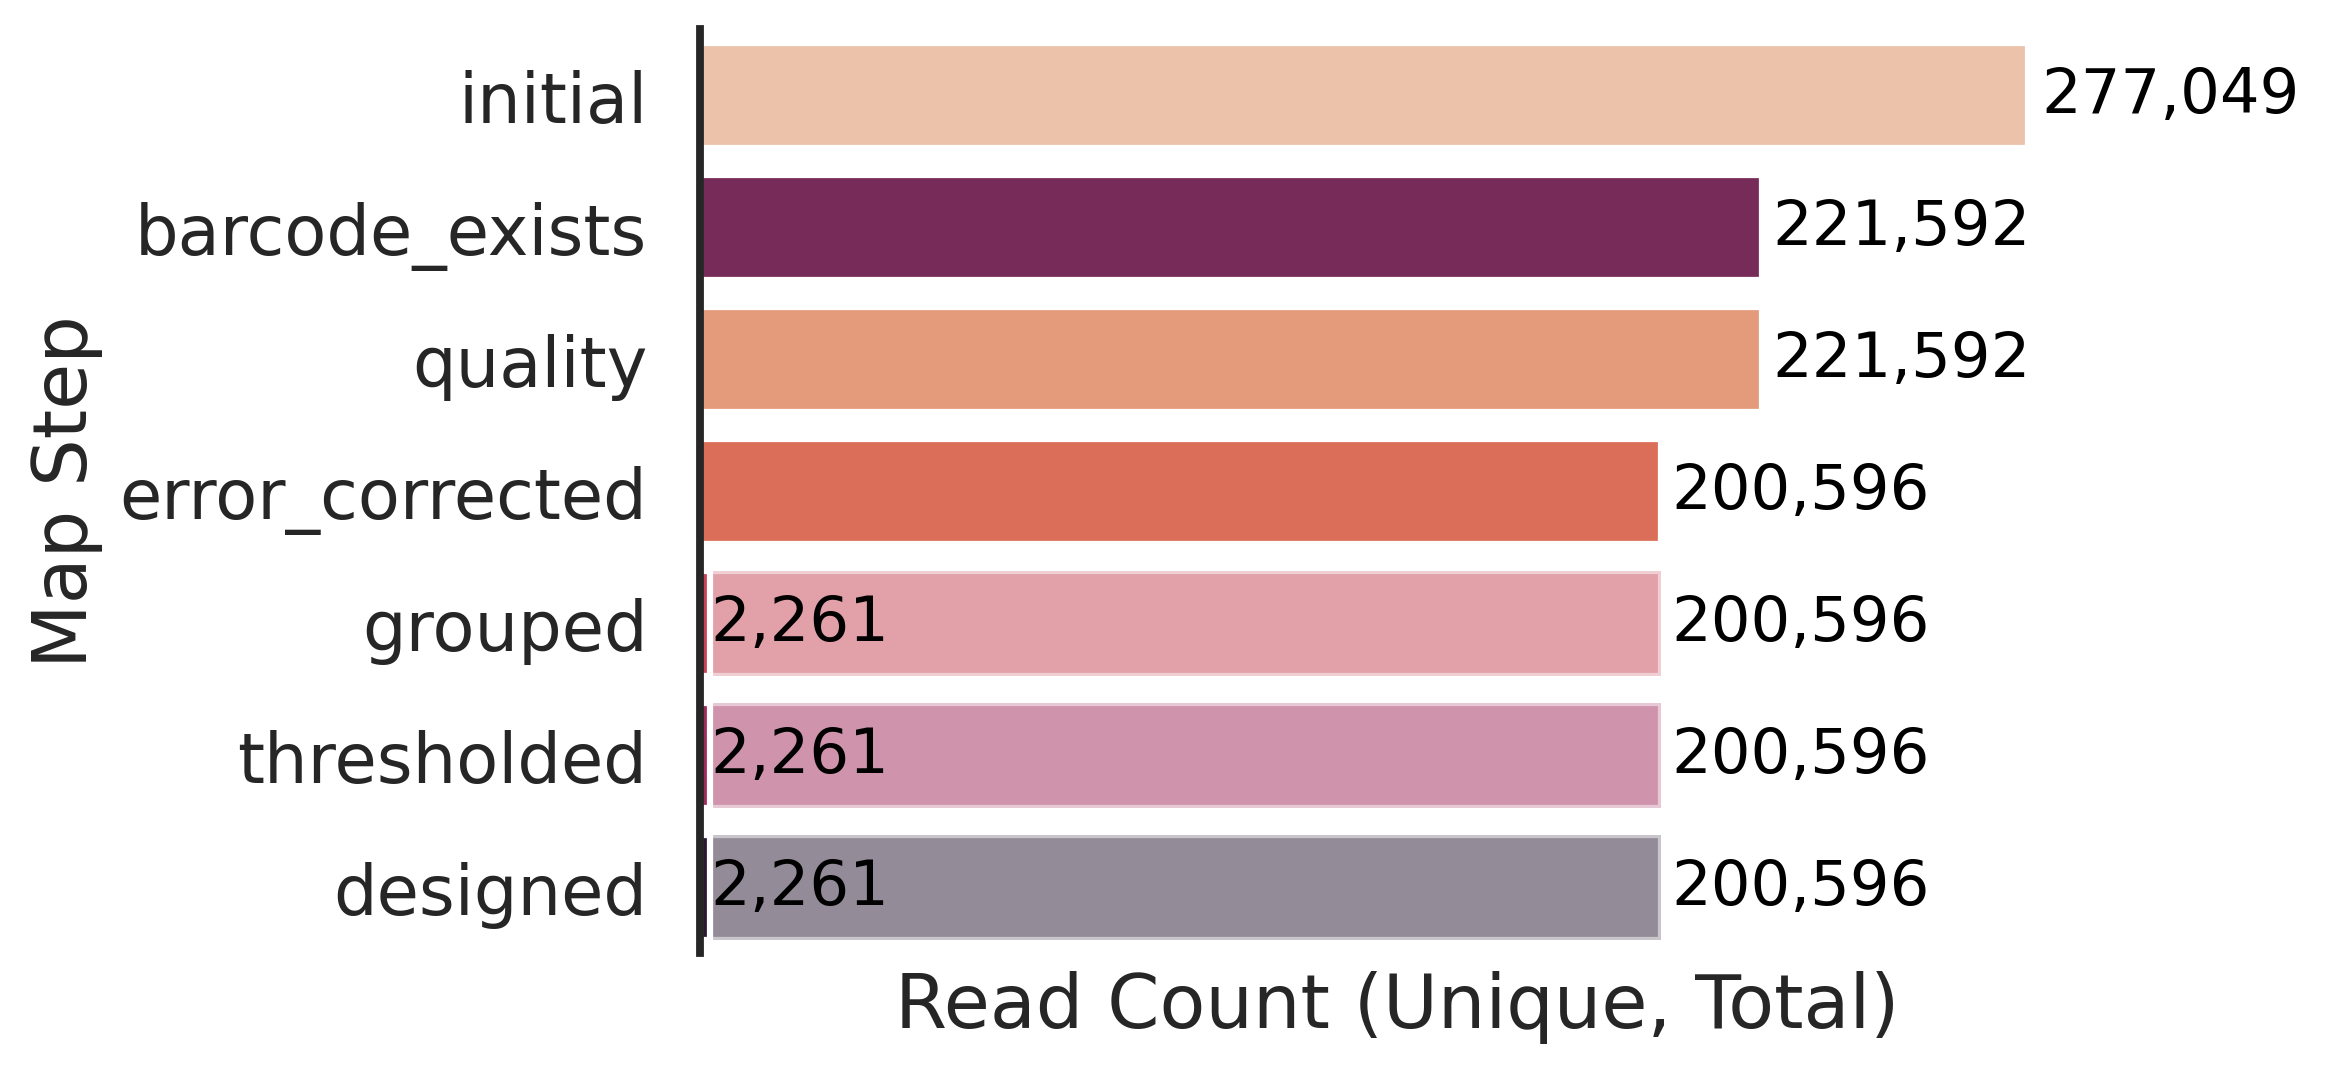

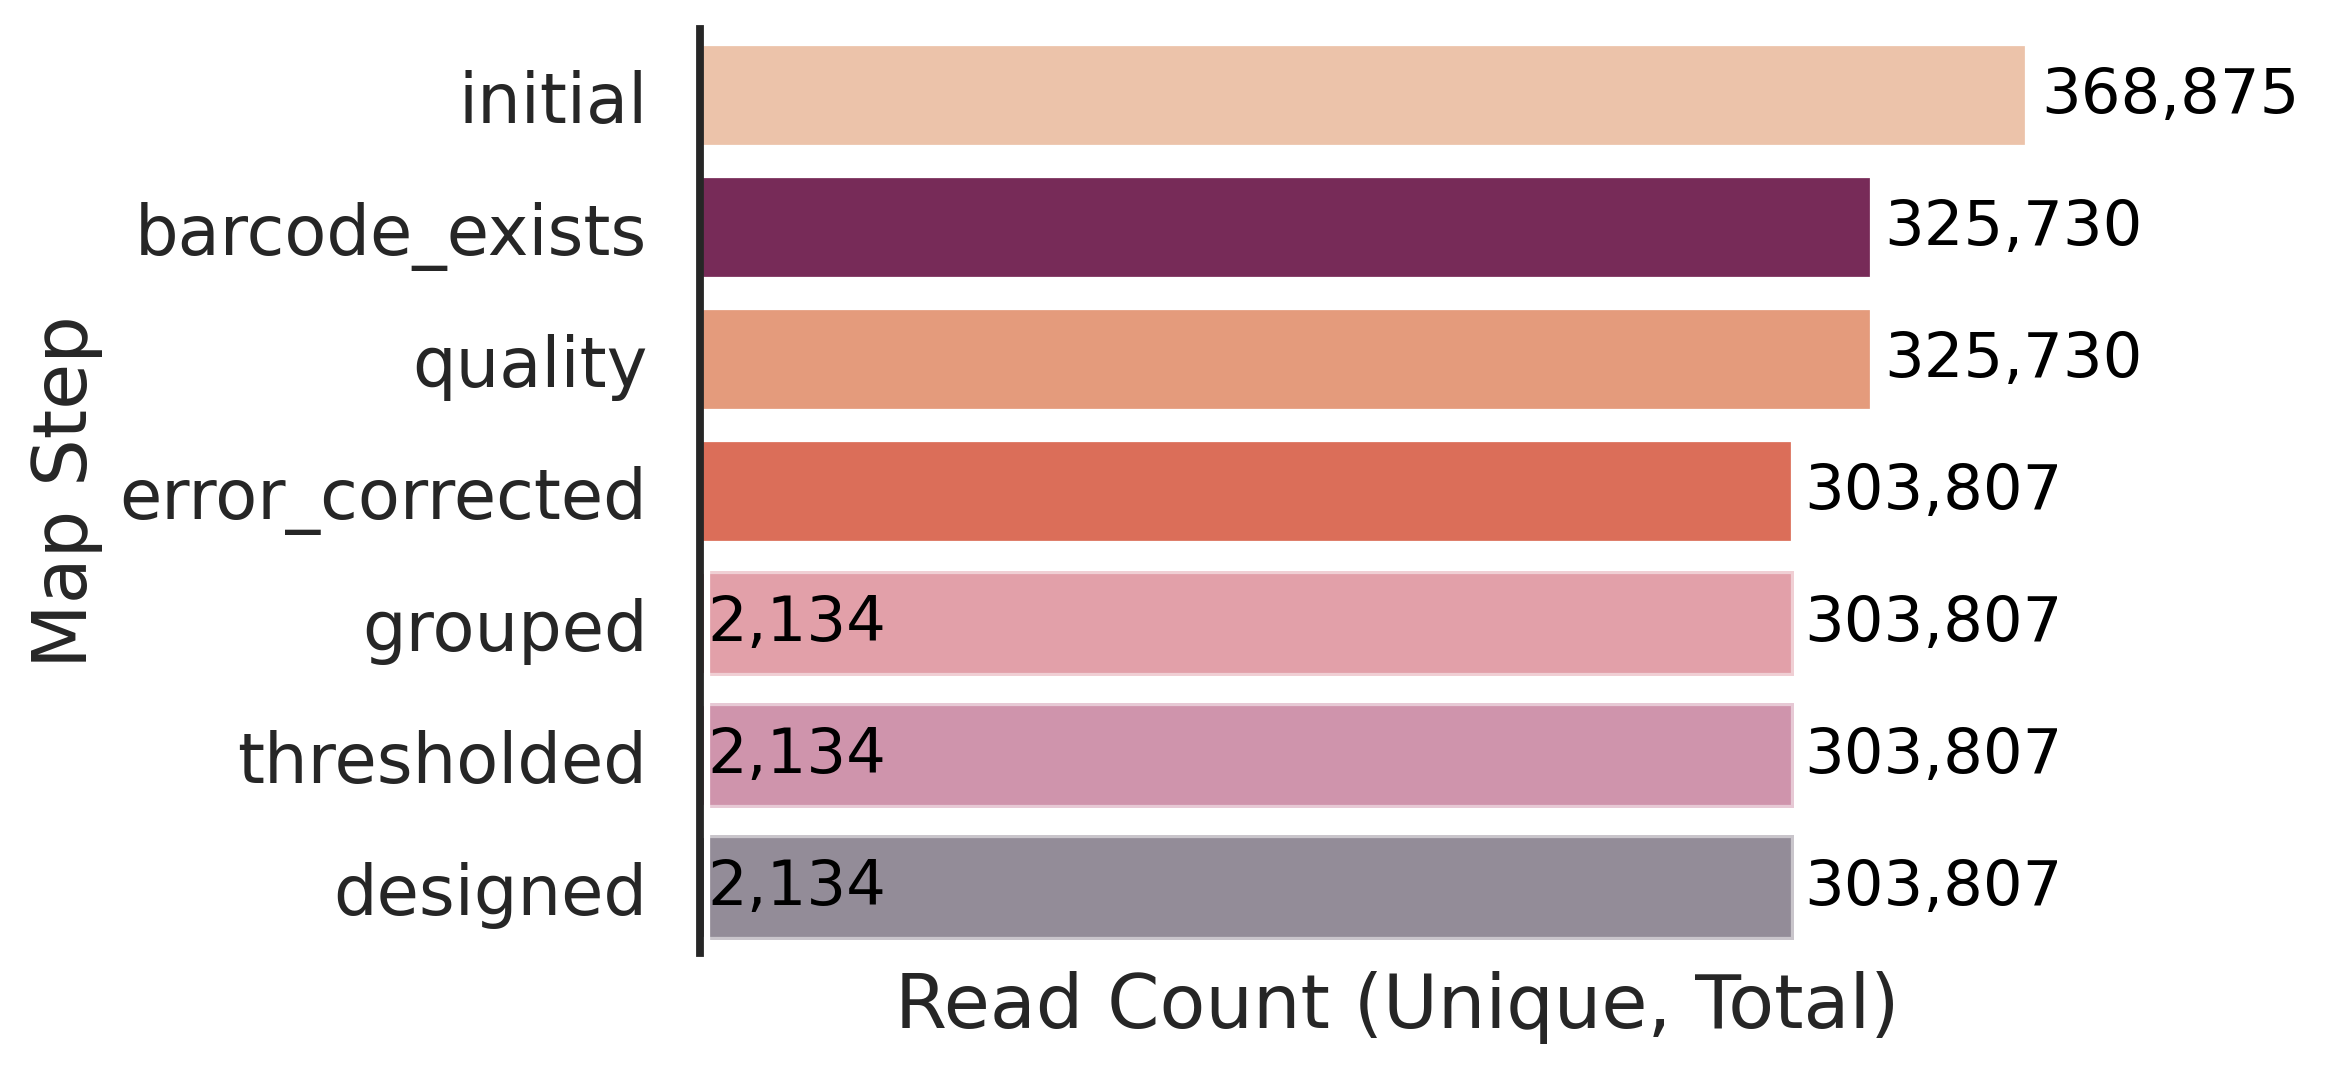

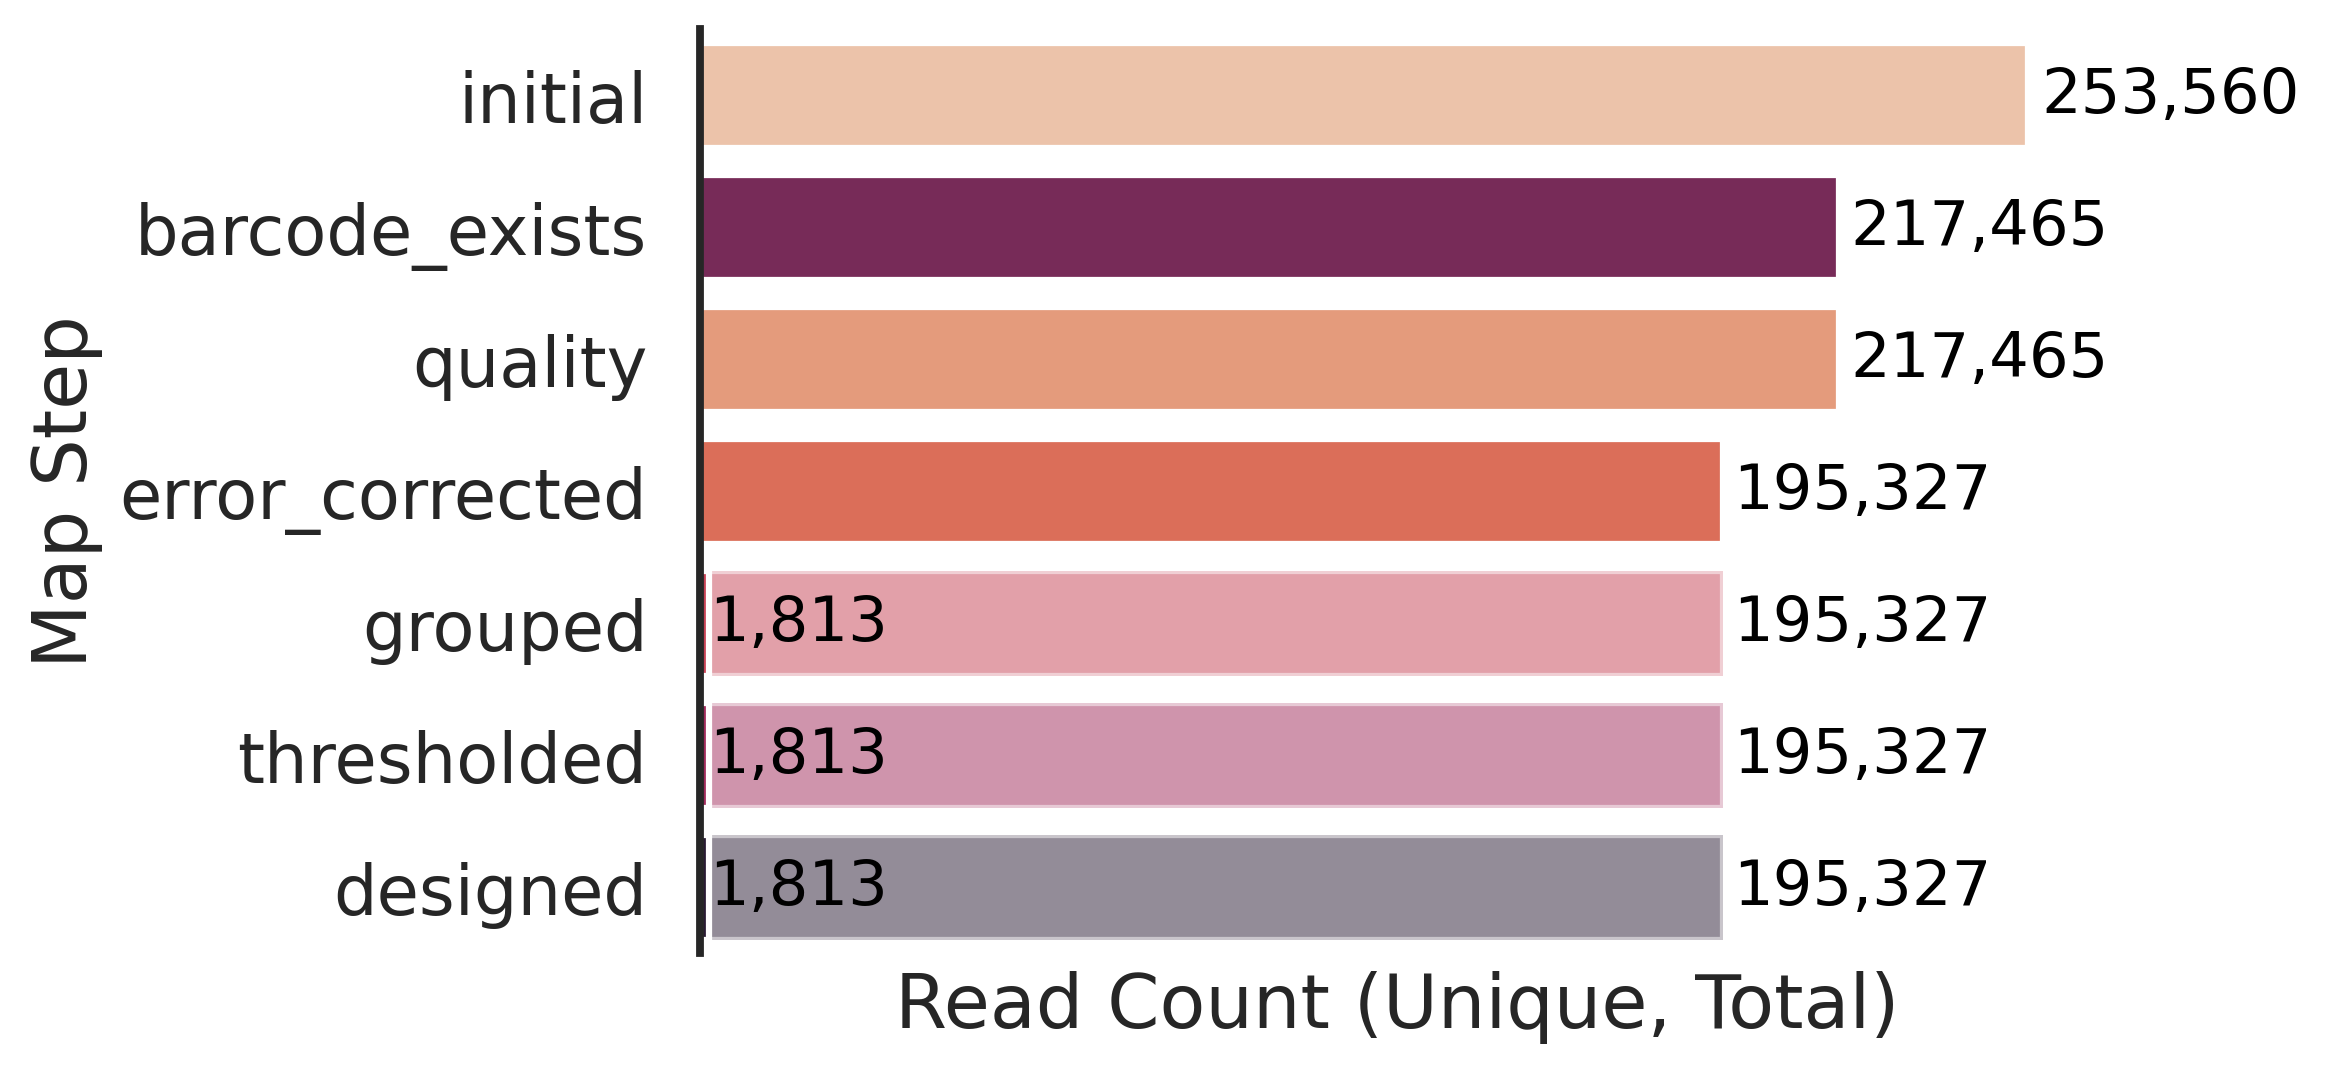

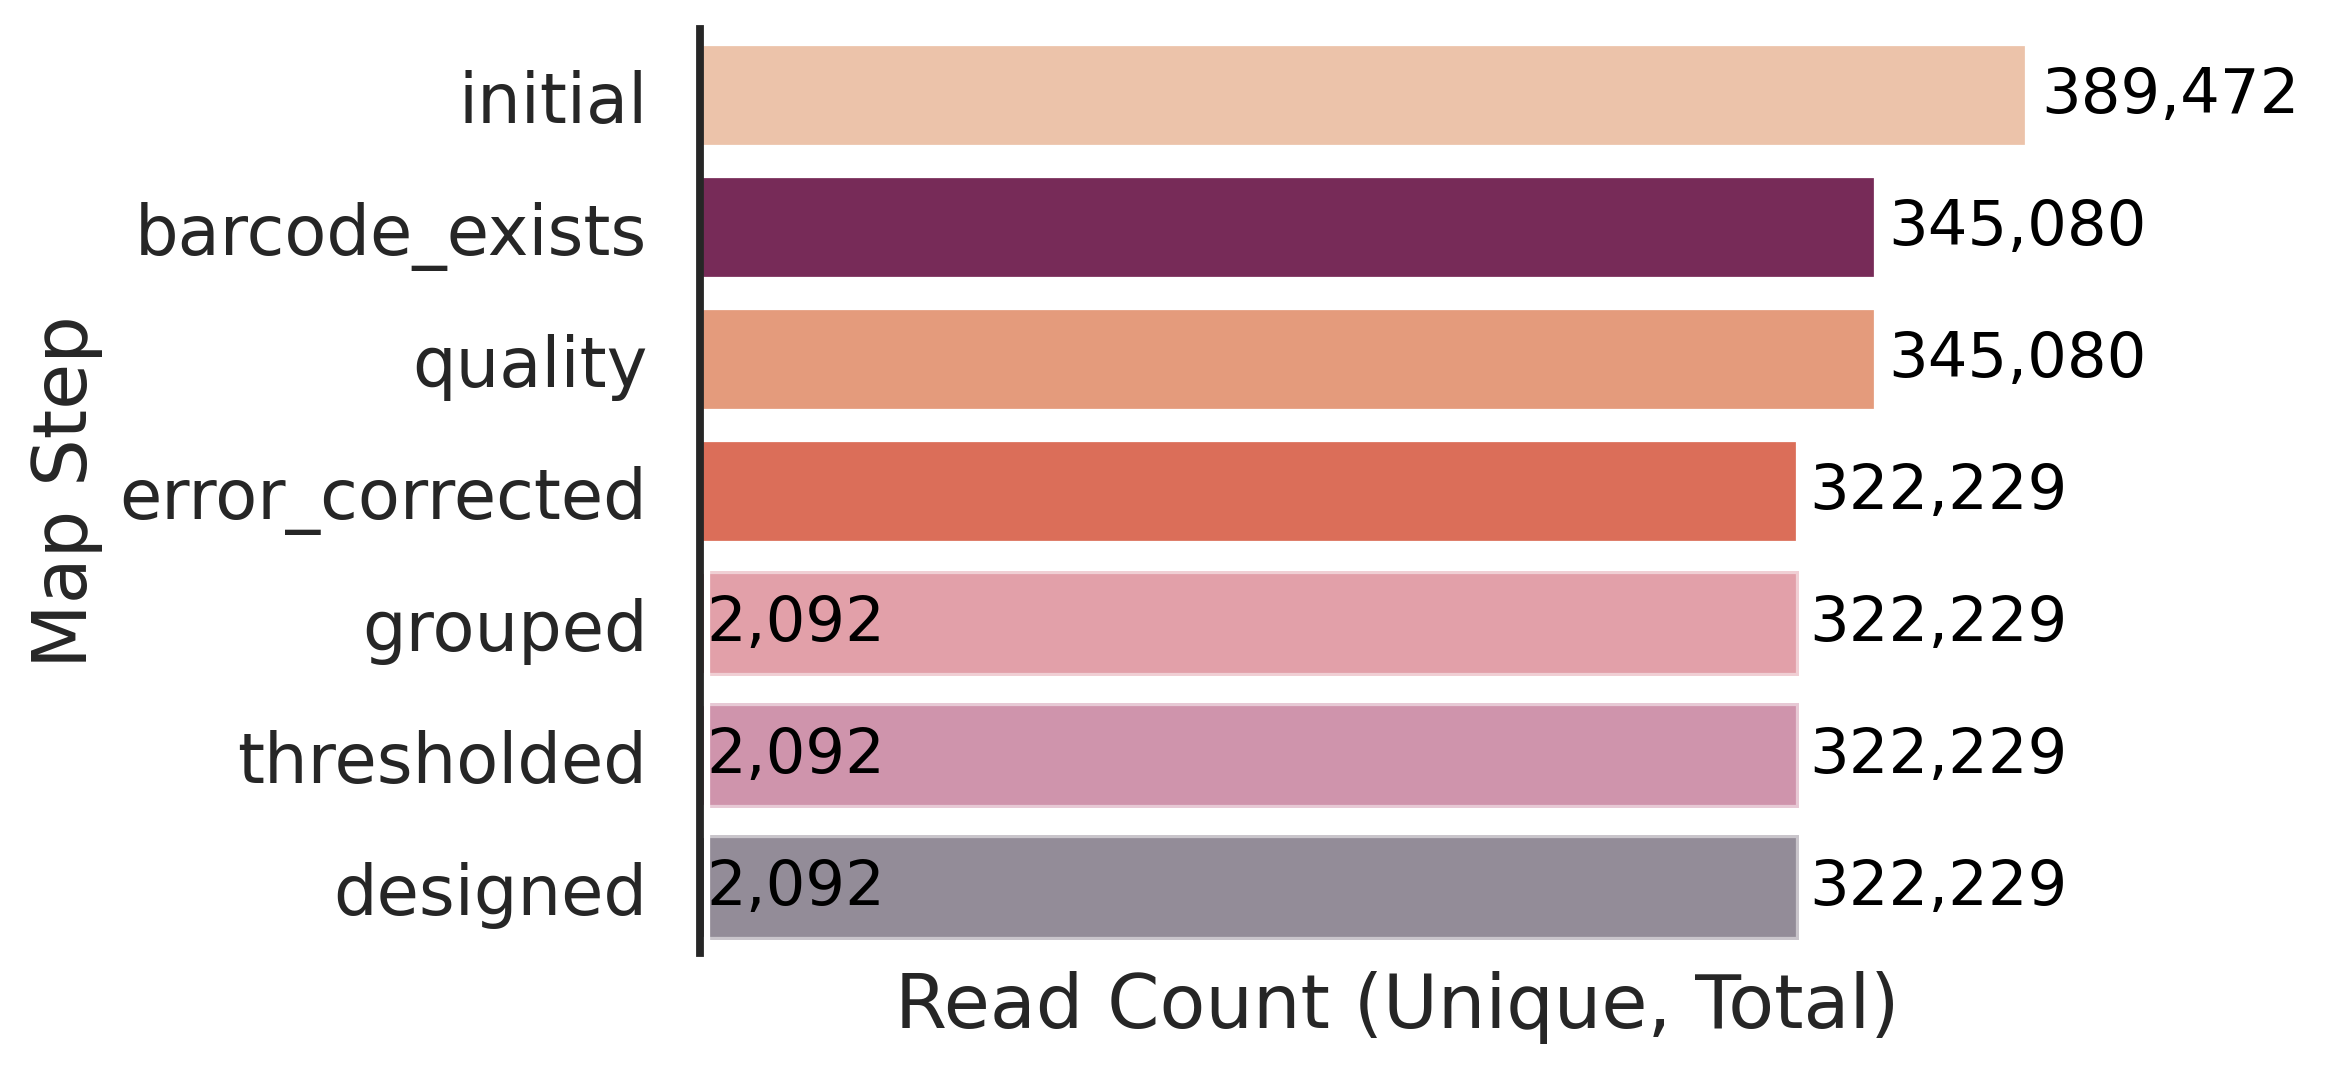

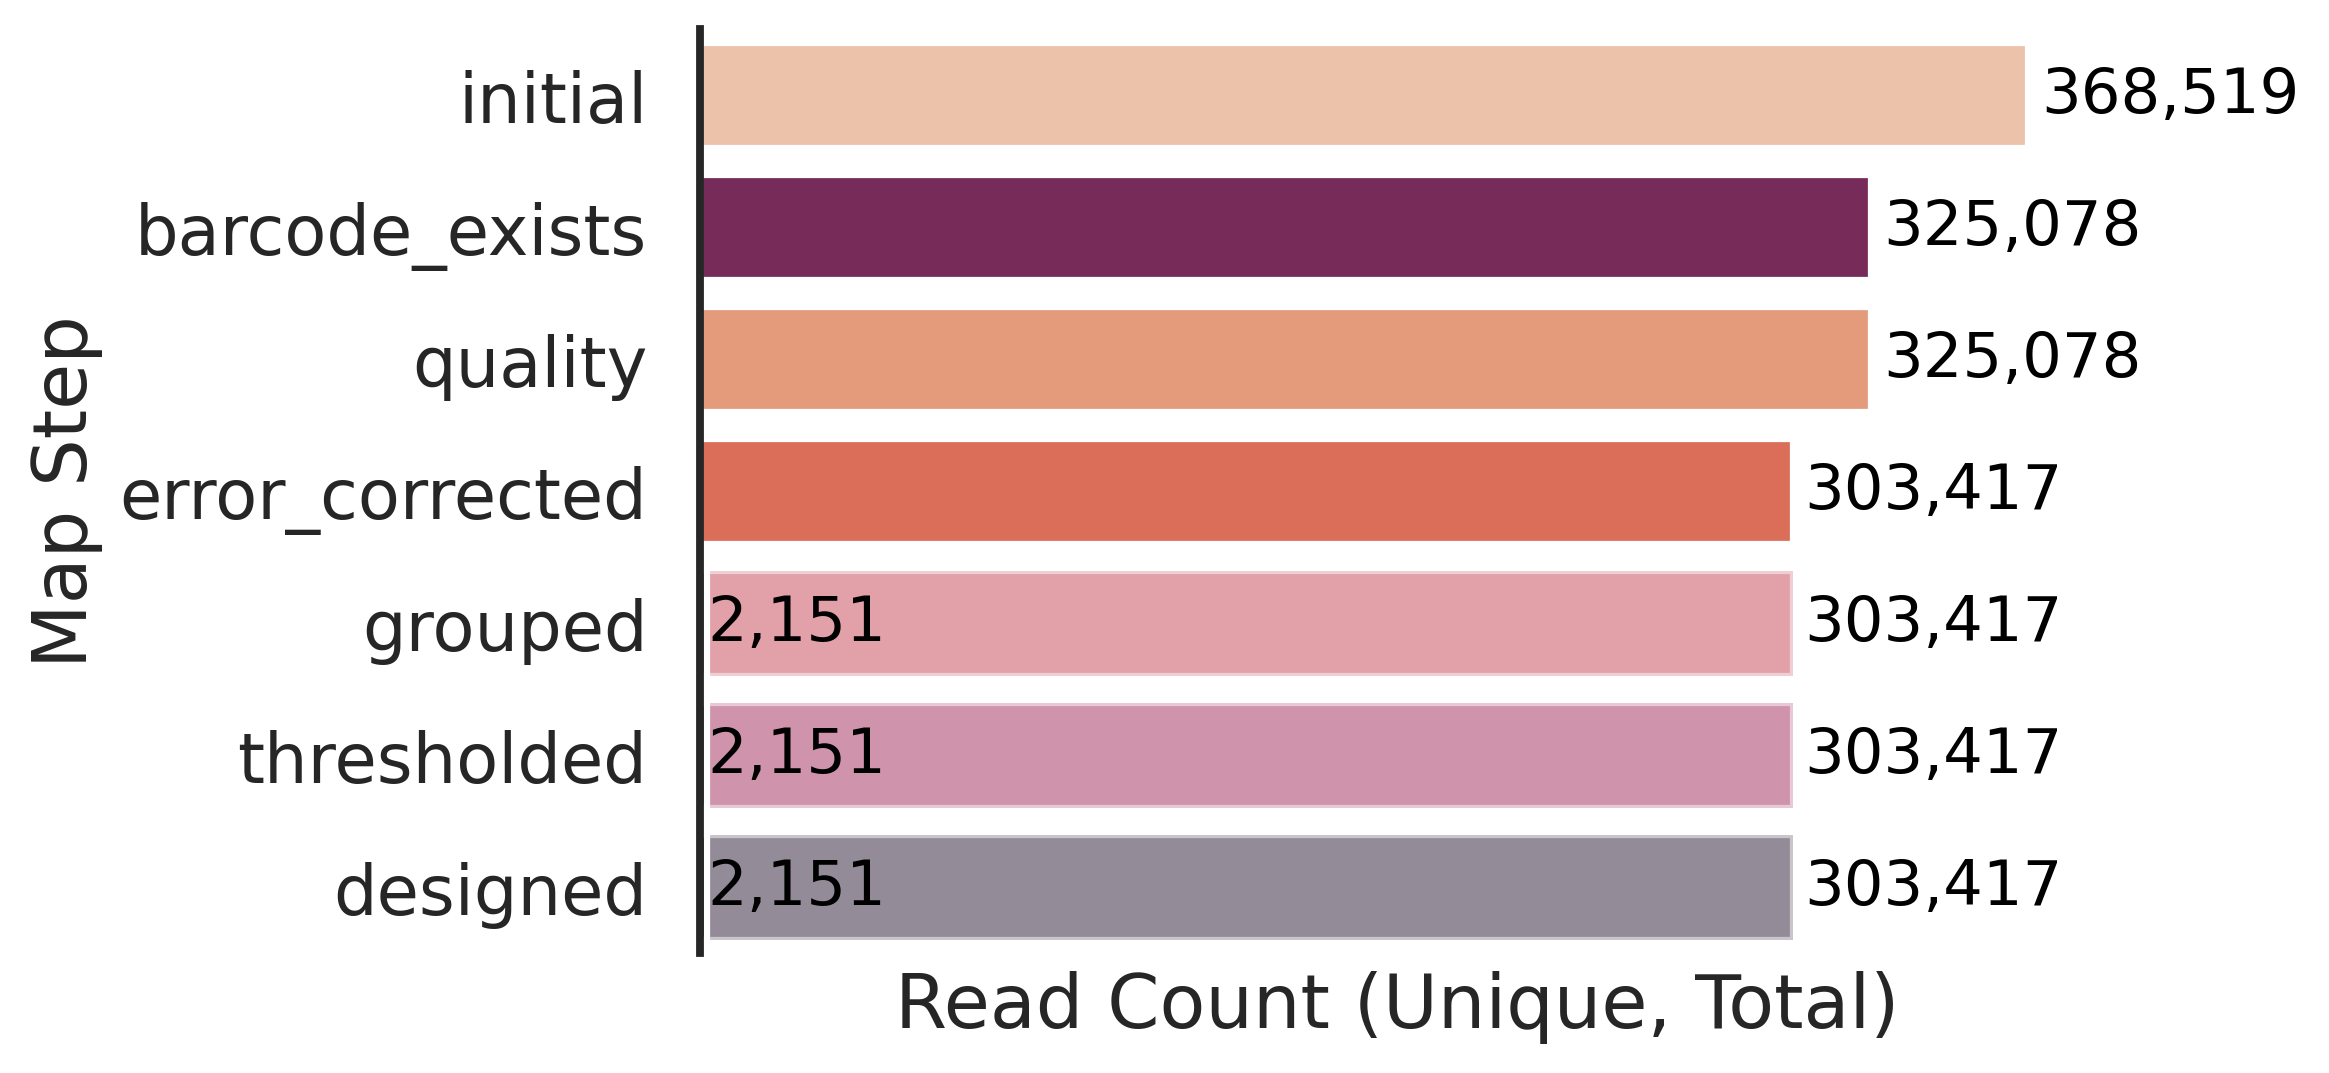

In [29]:
RPTR_objects = [EC_RPTR_BC]

for file_path in yeast_pool_A_RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = RPTR_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RPTR_objects,
                                        column_pairs = [],
                                        map_order = ['barcode_exists', 'quality', 'error_corrected', 'grouped', 'thresholded', 'designed'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = False,
                                        reads_threshold = 20,
                                        manual_ec_threshold=True,
                                        output_figures_path='/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/yeast_pool_C_umi/figures',
                                        plot_histograms=True)
    # refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [30]:
tables = refiner.show_tables()

yeast_pool_A_RPTR_result_tables = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0] and "RPTR" in table[0]:
        print(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_RPTR_result_tables.append(df)

yeast_pool_A_RPTR_result_df = pd.concat(yeast_pool_A_RPTR_result_tables)
yeast_pool_A_RPTR_result_df

trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded


,RPTR_BC,count,RPTR_BC_qual,Designed,sample
0,CCTGGGATATGAGT,1199,True,1,RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...
1,TGGGCCGGAATTGC,1086,True,1,RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...
2,GCTTCTCCGCACAT,1063,True,1,RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...
3,GTCCAGTTTAGTGA,1001,True,1,RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...
4,TTATTTAGAAGTTT,924,True,1,RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...
...,...,...,...,...,...
1808,TATCAAATAACCCG,21,True,1,RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...
1809,CTCGTAATAGTTTT,21,True,1,RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...
1810,CGAGCCCGGAGACT,21,True,1,RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...
1811,CCTTCGGATGTTCG,21,True,1,RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...


In [31]:
sum(yeast_pool_A_RPTR_result_df["count"])

1325376

In [32]:
yeast_pool_A_RPTR_result_df["sample"].value_counts()

sample
RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded          2261
RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded    2151
RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded    2134
RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded         2092
RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded          1813
Name: count, dtype: int64

## Yeast pool B

### 1. AD + ADBC

In [ ]:
yeast_pool_B_PolyT_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/*fastq")
yeast_pool_B_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/RPTR_reads/*fastq")
yeast_pool_B_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4_error_corrected/yeast_pool_B" # May need to change to your directory due to writing permissions